# Import Libraries

In [ ]:
#!pip install scipy==1.11.4
!pip install dalex
#!pip install scikit-plot
!pip install shap
!pip install lime

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import dalex as dx

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pd.set_option("display.max_columns", None)
df = pd.read_csv('/content/insurance_claims.csv')
df_desc = pd.read_csv('https://raw.githubusercontent.com/fadhlyfauzi/Final-Project-Dataset/refs/heads/main/insurance_claims.csv')

In [ ]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,NaN,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [ ]:
df.shape

(1000, 40)

## DATA OVERVIEW

Customer and Policy Information :
1. months_as_customer: Durasi hubungan nasabah dengan perusahaan asuransi.
2. age: Usia individu yang diasuransikan.
3. policy_number: Pengidentifikasi unik untuk polis asuransi.
4. policy_bind_date: Tanggal saat polis asuransi dimulai.
5. policy_state: Negara bagian tempat polis diterbitkan.
6. policy_csl: Tingkat Layanan Nasabah, yang kemungkinan menunjukkan tingkat layanan yang diberikan kepada nasabah.
7. policy_deductable: Jumlah yang dapat dikurangkan yang harus dibayarkan oleh tertanggung sebelum perusahaan asuransi menanggung klaim.
8. policy_annual_premium: Jumlah premi tahunan yang dibayarkan oleh tertanggung.
9. umbrella_limit: Cakupan kewajiban tambahan di luar batas polis utama.
10. insured_zip: Kode pos individu yang diasuransikan.
11. insured_sex: Jenis kelamin individu yang diasuransikan.
12. insured_education_level: Tingkat pendidikan individu yang diasuransikan.
13. insured_occupation: Pekerjaan individu yang diasuransikan.
14. insured_hobbies: Hobi individu yang diasuransikan. insured_relationship: Hubungan individu yang diasuransikan dengan pemegang polis utama.
15. capital-gains: Pendapatan keuntungan modal dari individu yang diasuransikan.
capital-loss: Pendapatan kerugian modal dari individu yang diasuransikan.


Incident Information :
1. incident_date: Tanggal kejadian.
2. insiden_type: Jenis kejadian (misalnya, tabrakan, pencurian).
3. collision_type: Jenis tabrakan (misalnya, tabrak belakang, benturan samping).
4. insiden_severity: Tingkat keparahan kejadian (misalnya, kerusakan kecil, kerugian total).
5. authority_contacted: Apakah pihak berwenang seperti polisi atau layanan darurat dihubungi.
6. insiden_state: Negara bagian tempat kejadian terjadi.
7. insiden_city: Kota tempat kejadian terjadi.
8. insiden_location: Lokasi spesifik kejadian.
9. insiden_hour_of_the_day: Jam saat kejadian terjadi.
10. number_of_vehicles_involved: Jumlah kendaraan yang terlibat dalam kejadian.
11. property_damage: Apakah kerusakan properti terjadi akibat kejadian.
12. bodily_injuries: Jumlah cedera tubuh yang dialami dalam kejadian.
13. wisdoms: Jumlah saksi mata kejadian.
14. policy_report_available: Apakah laporan polisi telah diajukan untuk kejadian tersebut.

Claim Information
1. total_claim_amount: Jumlah total yang diklaim oleh tertanggung.
2. injury_claim: Jumlah yang diklaim untuk cedera.
3. property_claim: Jumlah yang diklaim untuk kerusakan properti.
4. vehicle_claim: Jumlah yang diklaim untuk kerusakan kendaraan.

Vehicle Information
1. auto_make: Merek kendaraan yang terlibat dalam insiden.
2. auto_model: Model kendaraan yang terlibat dalam insiden.
3. auto_year: Tahun pembuatan kendaraan.

Variabel Target
1. fraud_reported: Apakah penipuan asuransi dilaporkan untuk klaim (biner: 'Ya' atau 'Tidak')


## Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

In [ ]:
df.replace('?', np.nan, inplace=True)

In [ ]:
df.isnull().sum()

,0
months_as_customer,0
age,0
policy_number,0
policy_bind_date,0
policy_state,0
policy_csl,0
policy_deductable,0
policy_annual_premium,0
umbrella_limit,0
insured_zip,0


In [ ]:
df['collision_type'] = df['collision_type'].fillna(df['collision_type'].mode()[0])
df['authorities_contacted'] = df['authorities_contacted'].fillna(df['authorities_contacted'].mode()[0])
df['property_damage'] = df['property_damage'].fillna(df['property_damage'].mode()[0])
df['police_report_available'] = df['police_report_available'].fillna(df['police_report_available'].mode()[0])

In [ ]:
df = df.drop(['_c39'], axis = 1)

In [ ]:
df.isna().sum()

,0
months_as_customer,0
age,0
policy_number,0
policy_bind_date,0
policy_state,0
policy_csl,0
policy_deductable,0
policy_annual_premium,0
umbrella_limit,0
insured_zip,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

In [ ]:
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
months_as_customer,1000.0,203.954,0.0,115.75,199.5,276.25,479.0,115.113174
age,1000.0,38.948,19.0,32.0,38.0,44.0,64.0,9.140287
policy_number,1000.0,546238.648,100804.0,335980.25,533135.0,759099.75,999435.0,257063.005276
policy_bind_date,1000,2002-02-08 04:40:47.999999872,1990-01-08 00:00:00,1995-09-19 00:00:00,2002-04-01 12:00:00,2008-04-21 12:00:00,2015-02-22 00:00:00,NaN
policy_deductable,1000.0,1136.0,500.0,500.0,1000.0,2000.0,2000.0,611.864673
policy_annual_premium,1000.0,1256.40615,433.33,1089.6075,1257.2,1415.695,2047.59,244.167395
umbrella_limit,1000.0,1101000.0,-1000000.0,0.0,0.0,0.0,10000000.0,2297406.598118
insured_zip,1000.0,501214.488,430104.0,448404.5,466445.5,603251.0,620962.0,71701.610941
capital-gains,1000.0,25126.1,0.0,0.0,0.0,51025.0,100500.0,27872.187708
capital-loss,1000.0,-26793.7,-111100.0,-51500.0,-23250.0,0.0,0.0,28104.096686


In [ ]:
for i in df.columns:
    if df[i].dtype == 'object':
        print(i, ":", df[i].nunique())

policy_state : 3
policy_csl : 3
insured_sex : 2
insured_education_level : 7
insured_occupation : 14
insured_hobbies : 20
insured_relationship : 6
incident_date : 60
incident_type : 4
collision_type : 3
incident_severity : 4
authorities_contacted : 4
incident_state : 7
incident_city : 7
incident_location : 1000
property_damage : 2
police_report_available : 2
auto_make : 14
auto_model : 39
fraud_reported : 2


Kolom-kolom seperti 'policy_state', 'policy_csl', 'incident_date', 'incident_state', 'incident_city' and 'incident_location tidak dimasukkan ke dalam model karena dianggap kurang relevan, memiliki informasi yang redundan, atau terlalu granular sehingga tidak memberikan kontribusi signifikan terhadap deteksi fraud.

In [ ]:
drop_columns = ['policy_state', 'policy_csl', 'incident_date', 'incident_state', 'incident_city', 'incident_location']
df = df.drop(drop_columns, axis = 1)
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,Vehicle Theft,Rear Collision,Minor Damage,Police,8,1,NO,0,0,NO,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,Police,5,1,NO,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,Vehicle Theft,Rear Collision,Minor Damage,Police,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [ ]:
for i in df.columns:
    if df[i].dtype == 'object':
        print(i, ":", df[i].nunique())

insured_sex : 2
insured_education_level : 7
insured_occupation : 14
insured_hobbies : 20
insured_relationship : 6
incident_type : 4
collision_type : 3
incident_severity : 4
authorities_contacted : 4
property_damage : 2
police_report_available : 2
auto_make : 14
auto_model : 39
fraud_reported : 2


Kolom fraud_reported akan digunakan sebagai target (label) dalam model prediksi. Nilainya akan dikonversi menjadi format biner, yaitu 1 untuk kasus fraud yang dilaporkan dan 0 untuk yang tidak dilaporkan, agar sesuai dengan kebutuhan algoritma pembelajaran mesin.

In [ ]:
df['fraud_reported'] = df['fraud_reported'].str.replace('Y', '1')
df['fraud_reported'] = df['fraud_reported'].str.replace('N', '0')
df['fraud_reported'] = df['fraud_reported'].astype(int)

In [ ]:
df['fraud_reported'].unique()

array([1, 0])

In [ ]:
df.isna().sum()

,0
months_as_customer,0
age,0
policy_number,0
policy_bind_date,0
policy_deductable,0
policy_annual_premium,0
umbrella_limit,0
insured_zip,0
insured_sex,0
insured_education_level,0


In [ ]:
df.duplicated().sum()

0

Tidak ditemukan data duplikat pada dataset

# Simple EDA

In [ ]:
df.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_deductable', 'policy_annual_premium', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted',
       'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'property_damage', 'bodily_injuries', 'witnesses',
       'police_report_available', 'total_claim_amount', 'injury_claim',
       'property_claim', 'vehicle_claim', 'auto_make', 'auto_model',
       'auto_year', 'fraud_reported'],
      dtype='object')

<ipython-input-28-290968a2cfa2>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='fraud_reported', data=df, palette='Blues')


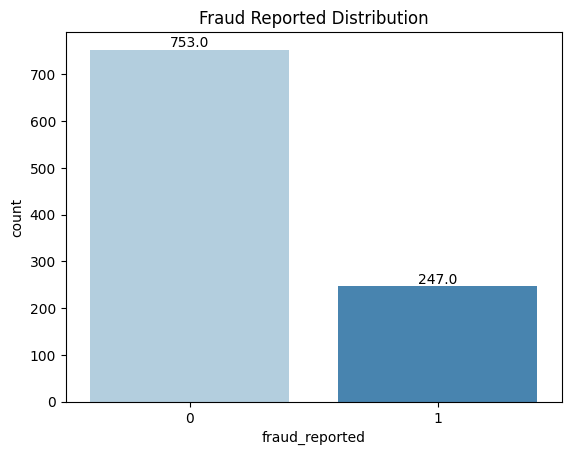

In [ ]:
ax = sns.countplot(x='fraud_reported', data=df, palette='Blues')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.title('Fraud Reported Distribution')
plt.show()

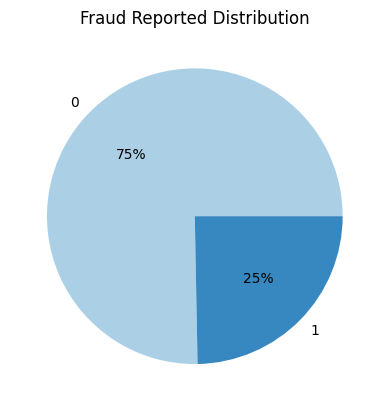

In [ ]:
satisfaction_counts = df['fraud_reported'].value_counts()
colors = sns.color_palette('Blues', len(satisfaction_counts))

plt.pie(satisfaction_counts, labels=satisfaction_counts.index, autopct='%.0f%%', colors=colors)

plt.title('Fraud Reported Distribution')
plt.show()

In [ ]:
num = df.select_dtypes(include = 'number').columns
cat = df.select_dtypes(include = 'object').columns

In [ ]:
len(num)

19

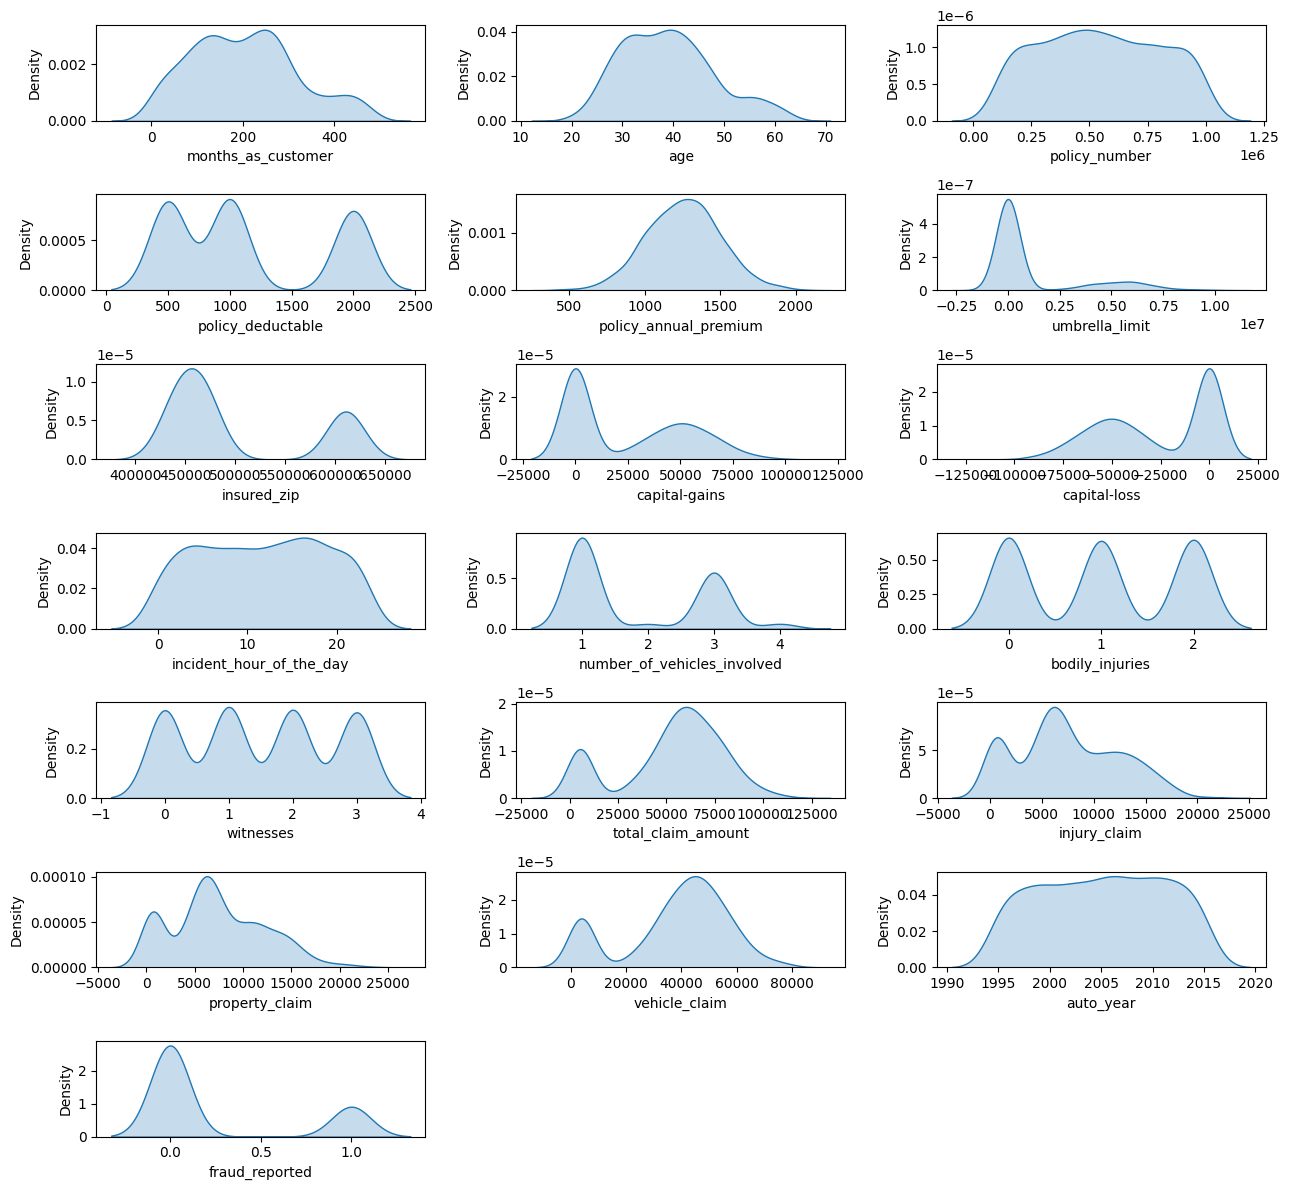

In [ ]:
plt.figure(figsize=(13,12)) # Increased figure height to accommodate more rows
for i in range(0, len(num)):
    plt.subplot(7,3, i+1) # Changed grid to 7x3 to accommodate 19 plots + 2 empty plots
    sns.kdeplot(data=df, x=df[num[i]], fill='True')
    plt.tight_layout()

<ipython-input-33-7d4280846b57>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fraud_reported', y=num[i], data=df, palette='Blues')
<ipython-input-33-7d4280846b57>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fraud_reported', y=num[i], data=df, palette='Blues')
<ipython-input-33-7d4280846b57>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fraud_reported', y=num[i], data=df, palette='Blues')
<ipython-input-33-7d4280846b57>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v

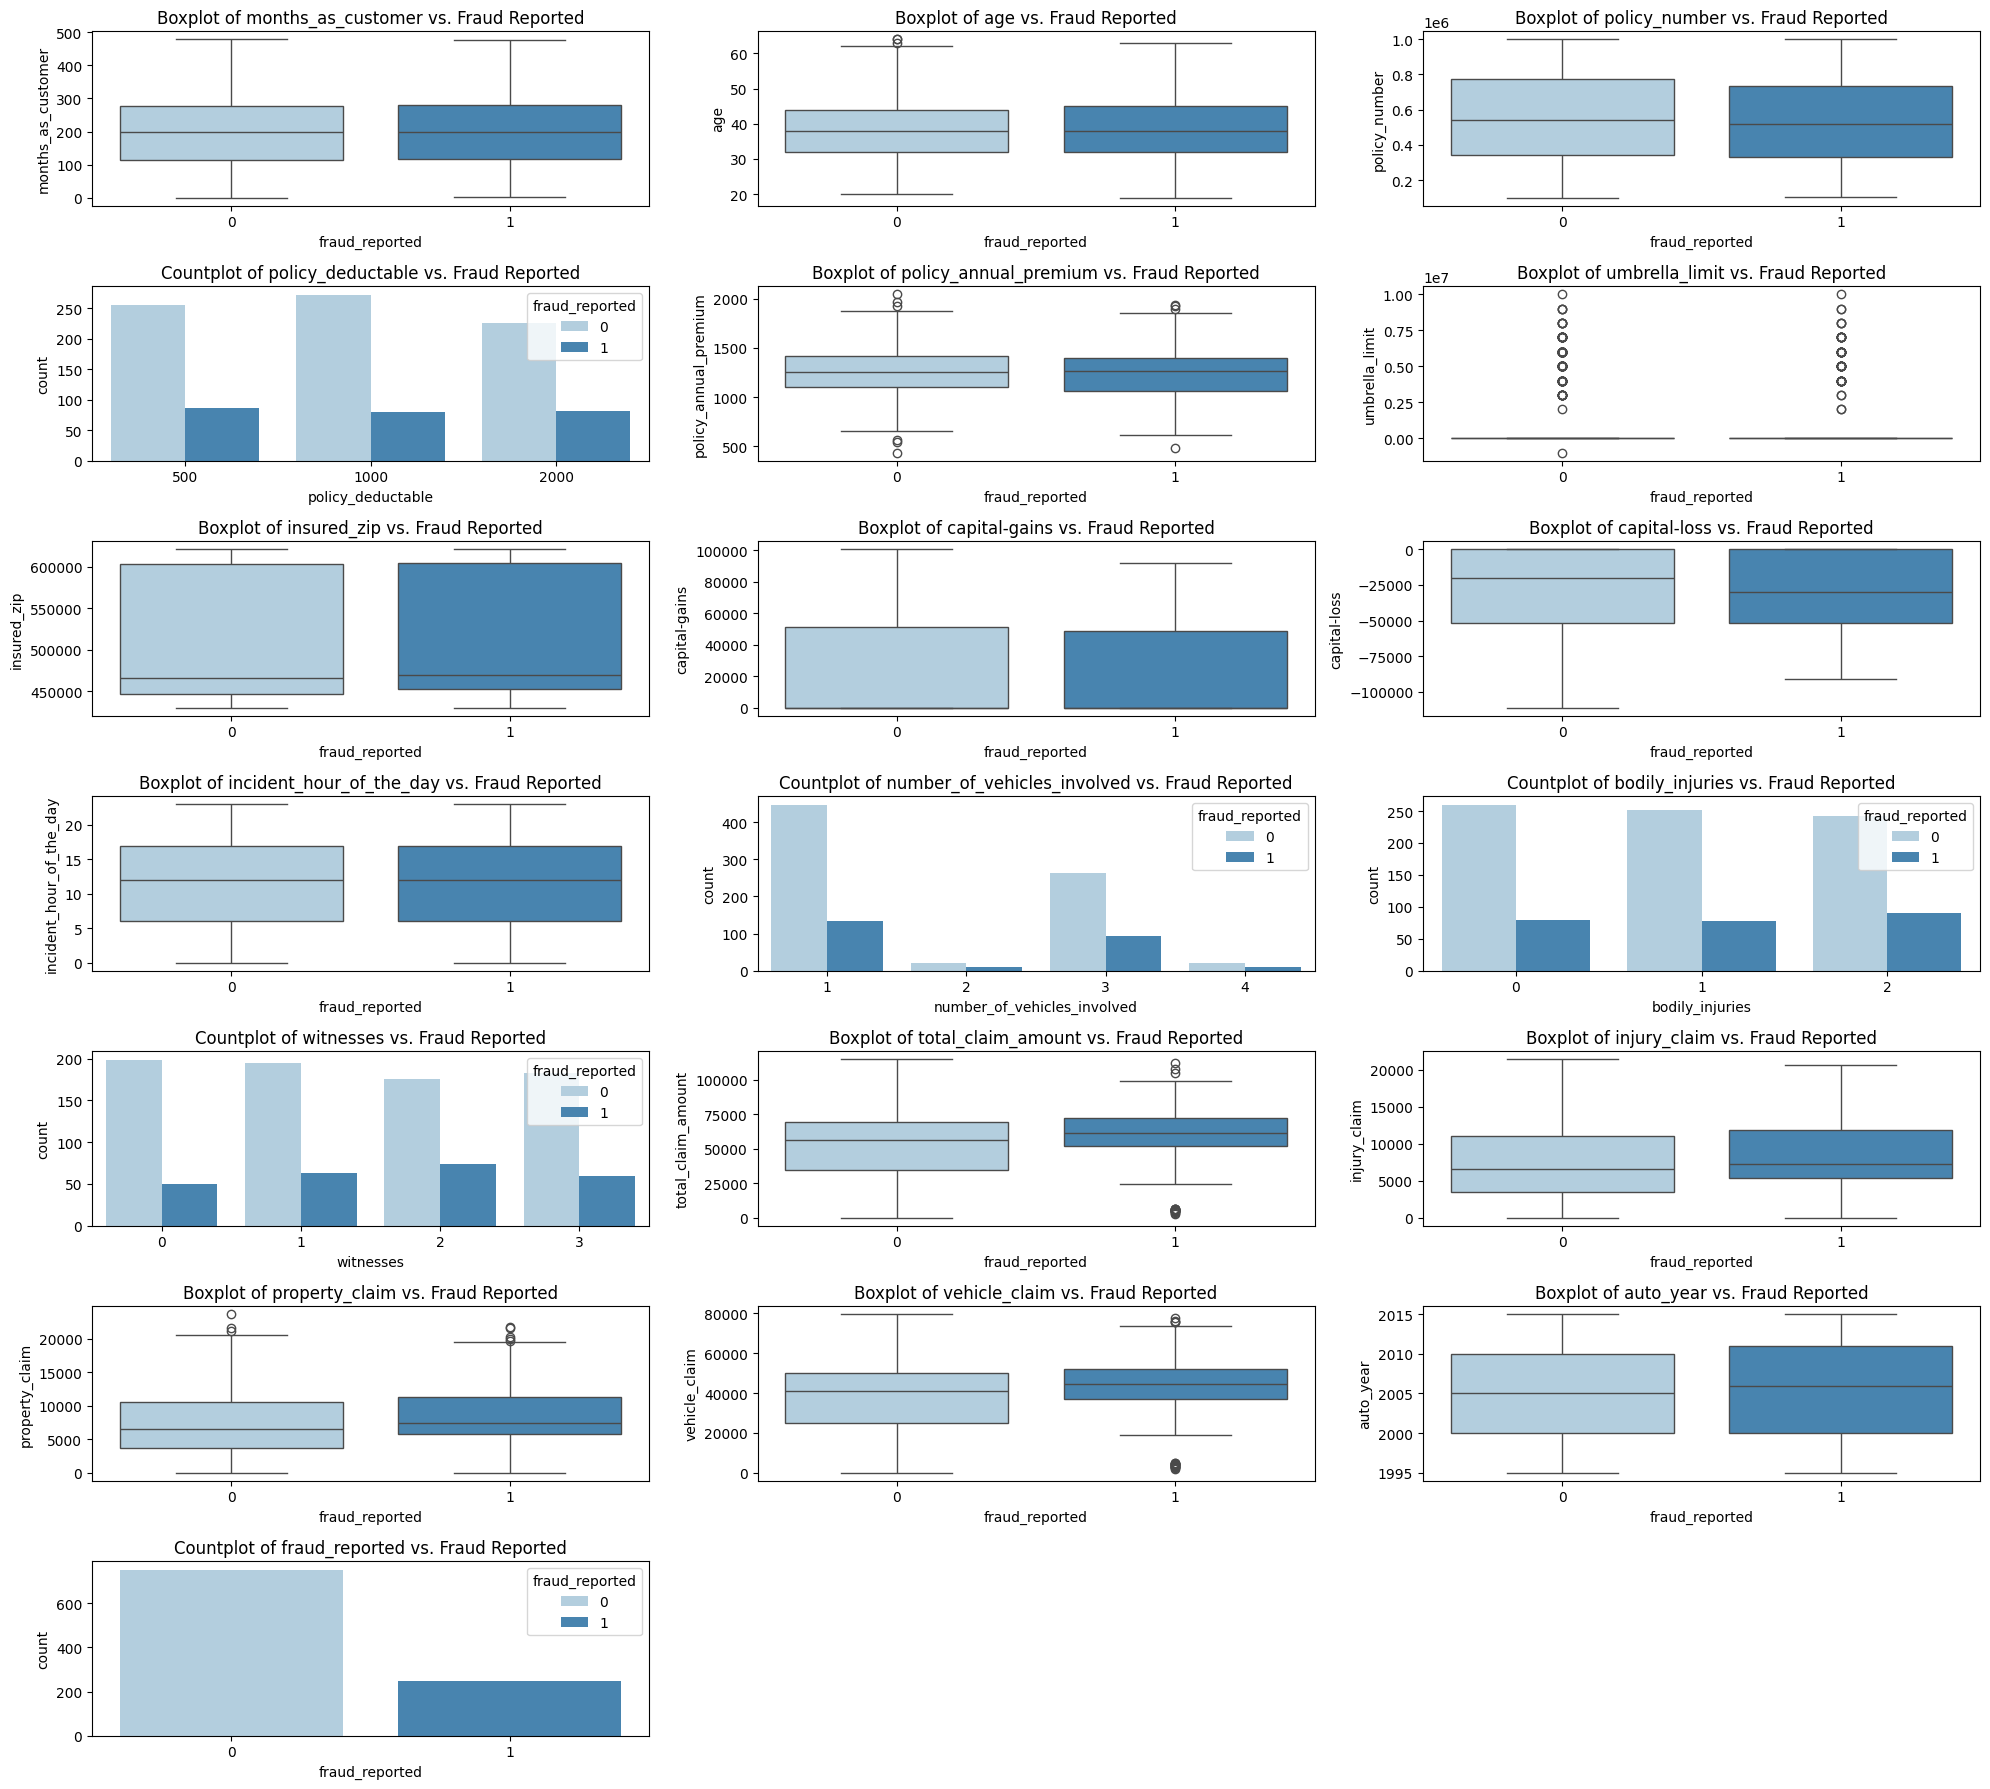

In [ ]:
plt.figure(figsize=(20, 18))  # Increased figure height for better visibility

# Adjusted grid layout to 7 rows and 3 columns to accommodate 19 plots + 2 empty plots
for i in range(0, len(num)):
    plt.subplot(7, 3, i + 1)

    if df[num[i]].nunique() < 6 or df[num[i]].nunique() < 7:
        sns.countplot(x=df[num[i]], hue='fraud_reported', data=df, palette='Blues')
        plt.title(f'Countplot of {num[i]} vs. Fraud Reported')
        plt.tight_layout()
    else:
        sns.boxplot(x='fraud_reported', y=num[i], data=df, palette='Blues')
        plt.title(f'Boxplot of {num[i]} vs. Fraud Reported')
        plt.tight_layout()

plt.show()

Faktor-faktor seperti policy_deductible, policy_annual_premium, capital-gains, number_of_vehicles_involved, bodily_injuries, dan total_claim_amount dapat menjadi indikator yang signifikan dalam mendeteksi adanya potensi fraud

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0.5, 0, 'months_as_customer'),
  Text(1.5, 0, 'age'),
  Text(2.5, 0, 'policy_number'),
  Text(3.5, 0, 'policy_deductable'),
  Text(4.5, 0, 'policy_annual_premium'),
  Text(5.5, 0, 'umbrella_limit'),
  Text(6.5, 0, 'insured_zip'),
  Text(7.5, 0, 'capital-gains'),
  Text(8.5, 0, 'capital-loss'),
  Text(9.5, 0, 'incident_hour_of_the_day'),
  Text(10.5, 0, 'number_of_vehicles_involved'),
  Text(11.5, 0, 'bodily_injuries'),
  Text(12.5, 0, 'witnesses'),
  Text(13.5, 0, 'total_claim_amount'),
  Text(14.5, 0, 'injury_claim'),
  Text(15.5, 0, 'property_claim'),
  Text(16.5, 0, 'vehicle_claim'),
  Text(17.5, 0, 'auto_year'),
  Text(18.5, 0, 'fraud_reported')])

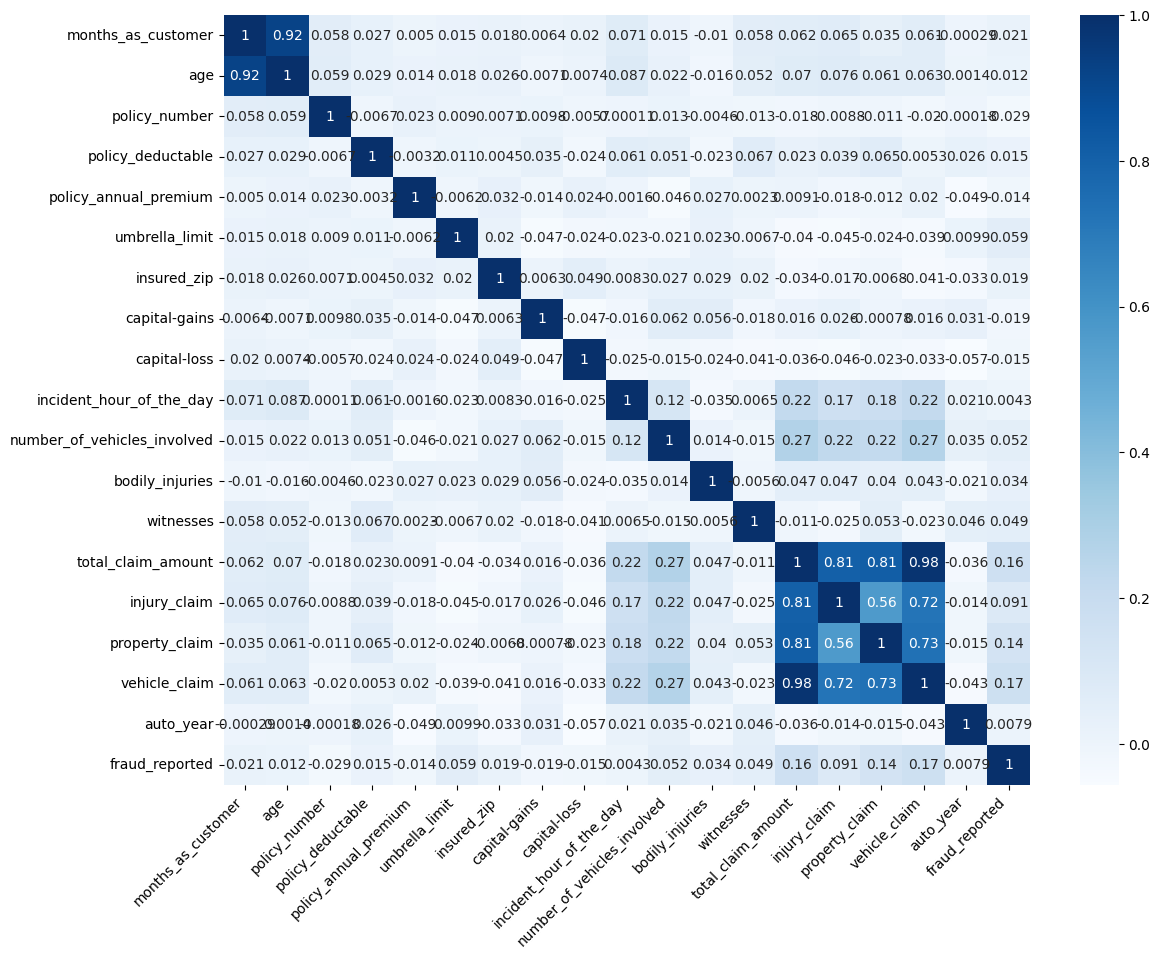

In [ ]:
plt.figure(figsize=(13,10))
corr = df[num].corr()
sns.heatmap(corr, annot = True, cmap='Blues')
plt.xticks(rotation=45, ha='right')

<ipython-input-35-d96cb4d7cb85>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], y=df[continu[col_index]], palette='Blues') # Accessing column directly
<ipython-input-35-d96cb4d7cb85>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], y=df[continu[col_index]], palette='Blues') # Accessing column directly
<ipython-input-35-d96cb4d7cb85>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], y=df[continu[col_index]], palette='Blues') # Accessing column directly
<ipython-input-35-d96cb4d7cb85>:10: FutureWarning: 


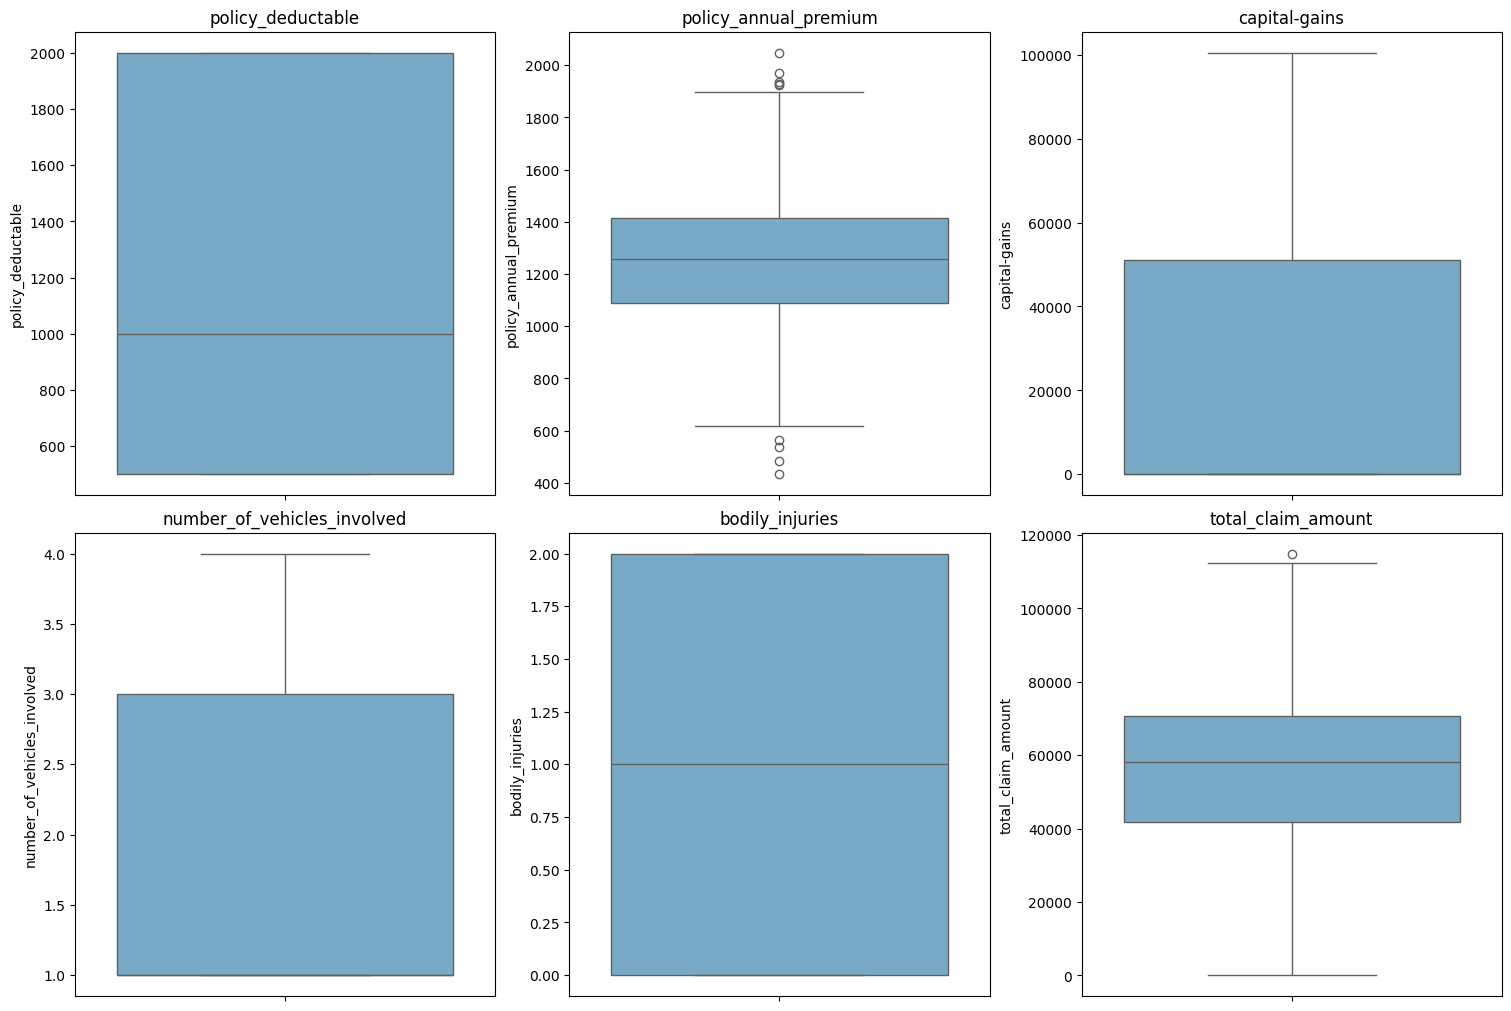

In [ ]:
fig, axes = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(15, 10), constrained_layout=True) # Adjusted for 6 plots

continu = ['policy_deductable', 'policy_annual_premium', 'capital-gains',
           'number_of_vehicles_involved', 'bodily_injuries', 'total_claim_amount']

# Flatten axes for easier iteration
axes = axes.flatten()
col_index = 0  # Initialize col_index before the loop
for i in range(len(axes)): # Loop through the flattened axes
    sns.boxplot(ax=axes[i], y=df[continu[col_index]], palette='Blues') # Accessing column directly
    axes[i].set_title(continu[col_index])
    col_index += 1

#EDA

<Axes: ylabel='count'>

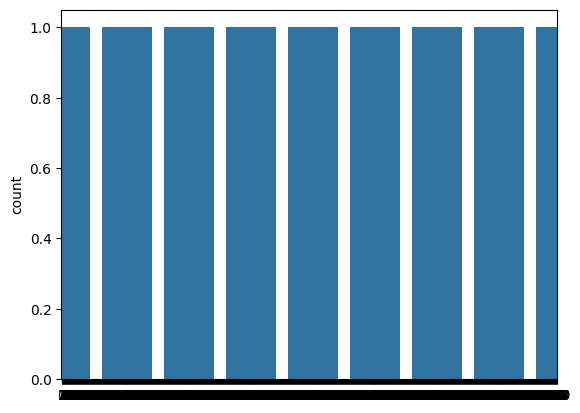

In [ ]:
sns.countplot(df['fraud_reported'])

Grafik menunjukkan distribusi yang seragam untuk setiap kategori atau variabel yang ditampilkan, dengan jumlah data yang relatif merata di seluruh kelompok. Tidak terlihat adanya ketidakseimbangan atau dominasi tertentu di dalam data.

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
months_as_customer,1000.0,203.954,0.0,115.75,199.5,276.25,479.0,115.113174
age,1000.0,38.948,19.0,32.0,38.0,44.0,64.0,9.140287
policy_number,1000.0,546238.648,100804.0,335980.25,533135.0,759099.75,999435.0,257063.005276
policy_bind_date,1000,2002-02-08 04:40:47.999999872,1990-01-08 00:00:00,1995-09-19 00:00:00,2002-04-01 12:00:00,2008-04-21 12:00:00,2015-02-22 00:00:00,NaN
policy_deductable,1000.0,1136.0,500.0,500.0,1000.0,2000.0,2000.0,611.864673
policy_annual_premium,1000.0,1256.40615,433.33,1089.6075,1257.2,1415.695,2047.59,244.167395
umbrella_limit,1000.0,1101000.0,-1000000.0,0.0,0.0,0.0,10000000.0,2297406.598118
insured_zip,1000.0,501214.488,430104.0,448404.5,466445.5,603251.0,620962.0,71701.610941
capital-gains,1000.0,25126.1,0.0,0.0,0.0,51025.0,100500.0,27872.187708
capital-loss,1000.0,-26793.7,-111100.0,-51500.0,-23250.0,0.0,0.0,28104.096686


In [ ]:
df.describe(include='object').T

,count,unique,top,freq
insured_sex,1000,2,FEMALE,537
insured_education_level,1000,7,JD,161
insured_occupation,1000,14,machine-op-inspct,93
insured_hobbies,1000,20,reading,64
insured_relationship,1000,6,own-child,183
incident_type,1000,4,Multi-vehicle Collision,419
collision_type,1000,3,Rear Collision,470
incident_severity,1000,4,Minor Damage,354
authorities_contacted,1000,4,Police,383
property_damage,1000,2,NO,698


In [ ]:
df.isna().sum()

,0
months_as_customer,0
age,0
policy_number,0
policy_bind_date,0
policy_deductable,0
policy_annual_premium,0
umbrella_limit,0
insured_zip,0
insured_sex,0
insured_education_level,0


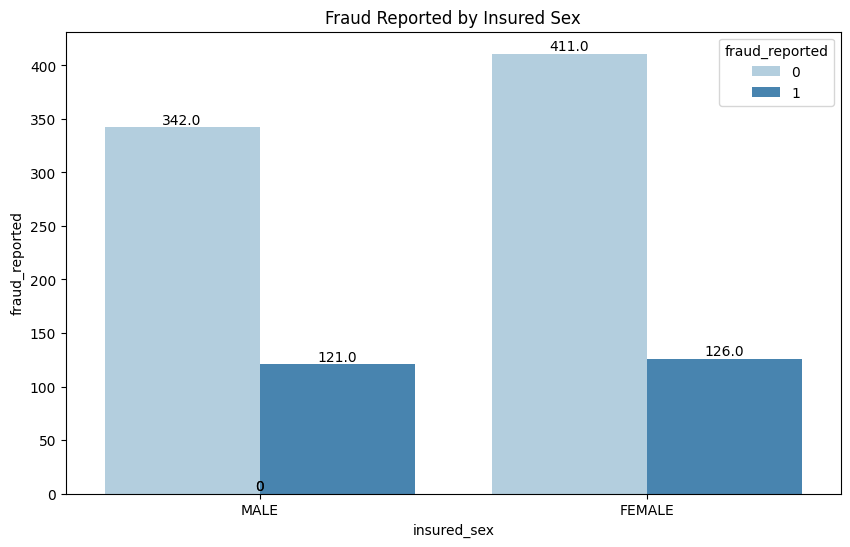

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='insured_sex', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by Insured Sex')
plt.xlabel('insured_sex')
plt.ylabel('fraud_reported')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

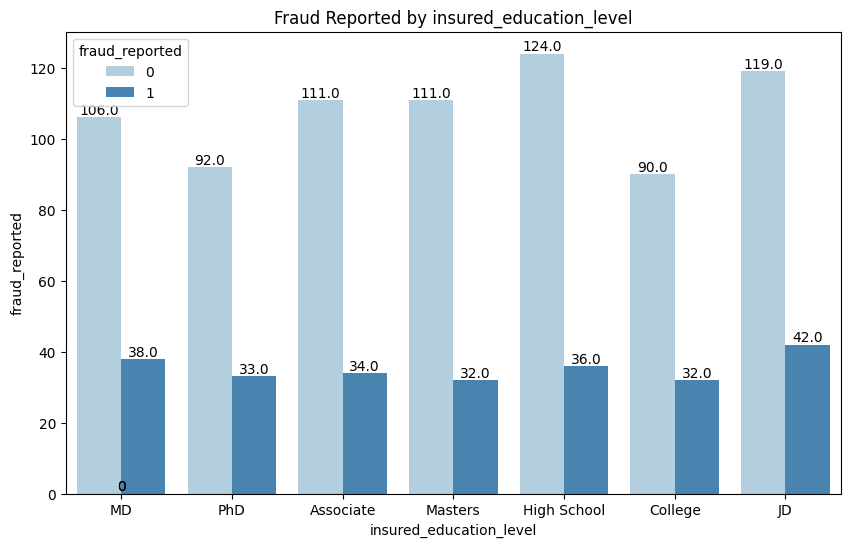

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='insured_education_level', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by insured_education_level')
plt.xlabel('insured_education_level')
plt.ylabel('fraud_reported')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

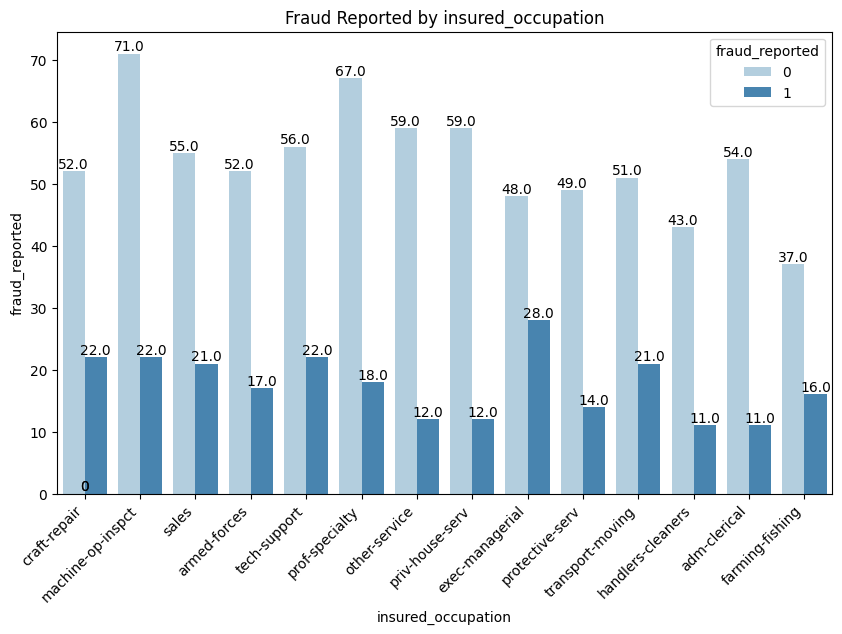

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='insured_occupation', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by insured_occupation')
plt.xlabel('insured_occupation')
plt.ylabel('fraud_reported')

plt.xticks(rotation=45, ha='right')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

Dari data tersebut, terlihat bahwa orang-orang yang menduduki posisi eksekutif-manajerial memiliki jumlah penipuan yang lebih tinggi dibandingkan dengan pekerjaan lainnya.

Penjualan, dukungan teknis, dan transportasi juga memiliki kasus penipuan yang relatif tinggi.

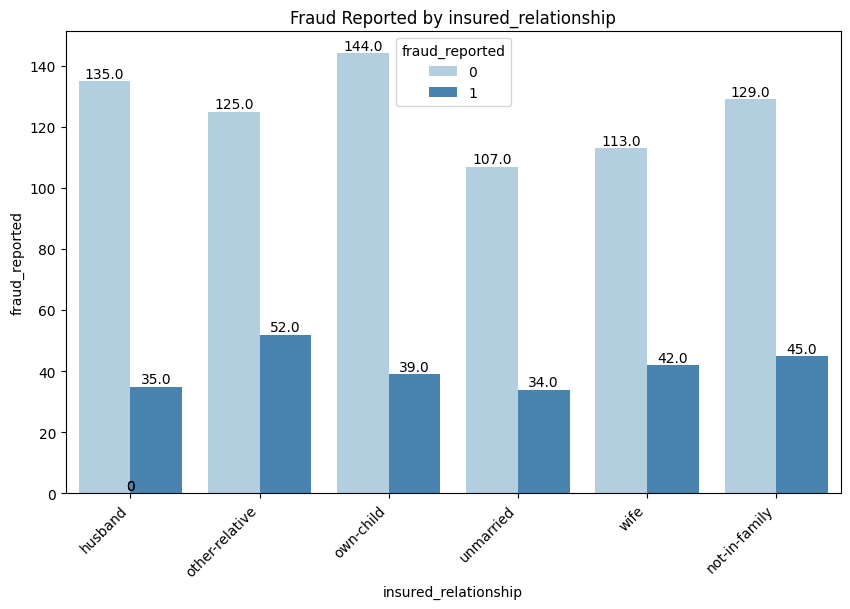

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='insured_relationship', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by insured_relationship')
plt.xlabel('insured_relationship')
plt.ylabel('fraud_reported')

plt.xticks(rotation=45, ha='right')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

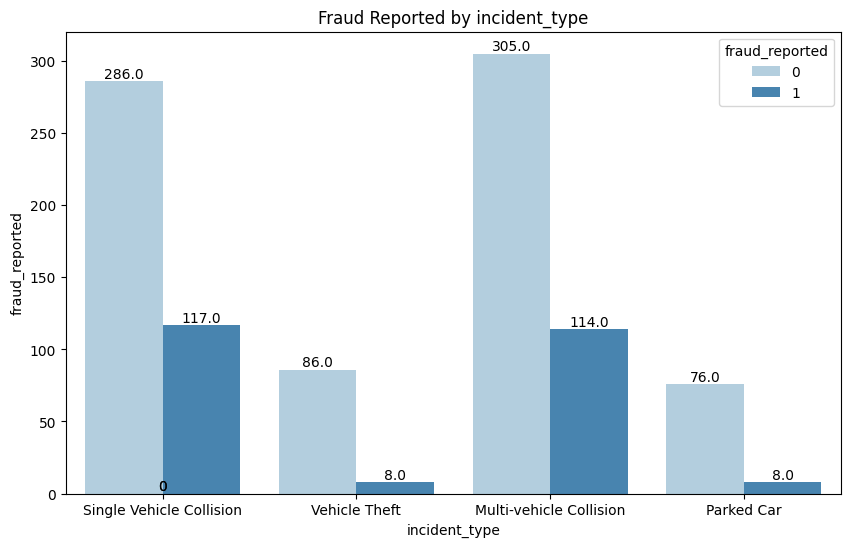

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='incident_type', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by incident_type')
plt.xlabel('incident_type')
plt.ylabel('fraud_reported')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

Tabrakan yang melibatkan banyak kendaraan dan satu kendaraan memiliki jumlah penipuan yang lebih banyak dibandingkan dengan pencurian kendaraan dan pencurian parkir. Salah satu alasannya adalah bahwa dalam sebuah tabrakan, ada kemungkinan besar kerusakan yang lebih besar pada mobil, serta penumpang dan karenanya perlu mengajukan klaim asuransi palsu.

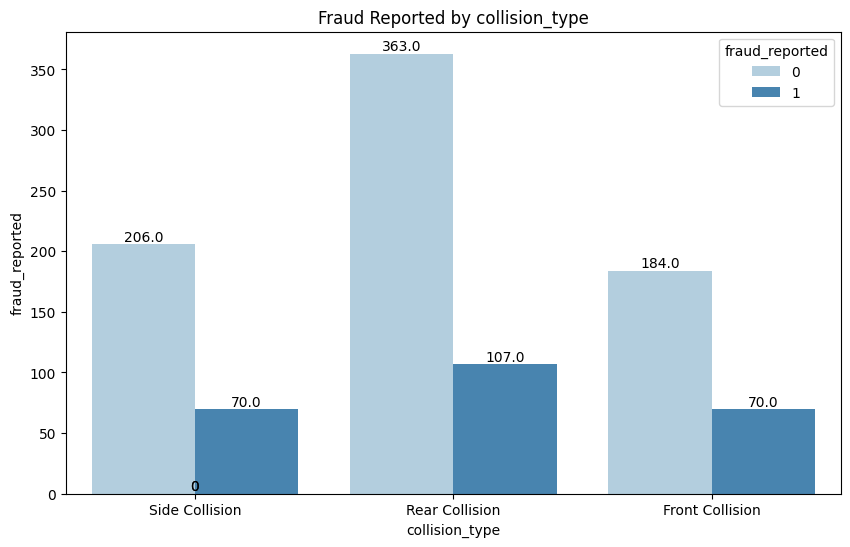

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='collision_type', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by collision_type')
plt.xlabel('collision_type')
plt.ylabel('fraud_reported')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

Meskipun ada sejumlah besar klaim palsu pada tabrakan depan dan samping, tabrakan belakang adalah yang tertinggi.

Data ini untuk AS dan di sana, banyak orang menggunakan kamera dasbor saat mengemudi untuk merekam apa pun yang terjadi saat mereka mengemudi. Pada tabrakan belakang, rekaman dari kamera dasbor tidak terlalu membantu untuk membuktikan secara meyakinkan siapa yang salah (pemilik asuransi atau pemilik mobil lainnya). Mungkin itulah alasan untuk lebih banyak klaim penipuan pada tabrakan belakang.

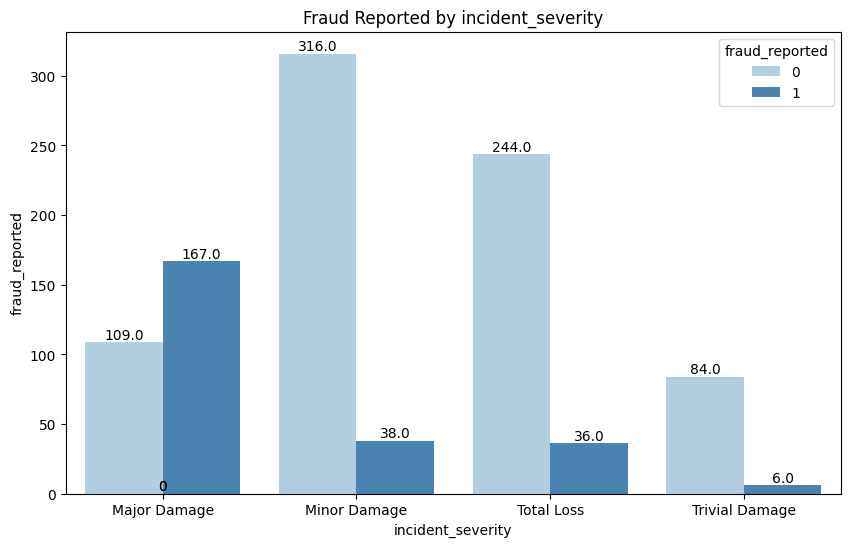

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='incident_severity', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by incident_severity')
plt.xlabel('incident_severity')
plt.ylabel('fraud_reported')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

Di sini, dibandingkan dengan kerusakan kecil, kerugian total, dan kerusakan sepele, klaim penipuan paling tinggi terjadi pada kerusakan besar.

Salah satu alasannya bisa jadi karena tingginya biaya perbaikan yang akan dikeluarkan oleh perusahaan asuransi akibat kerusakan besar.

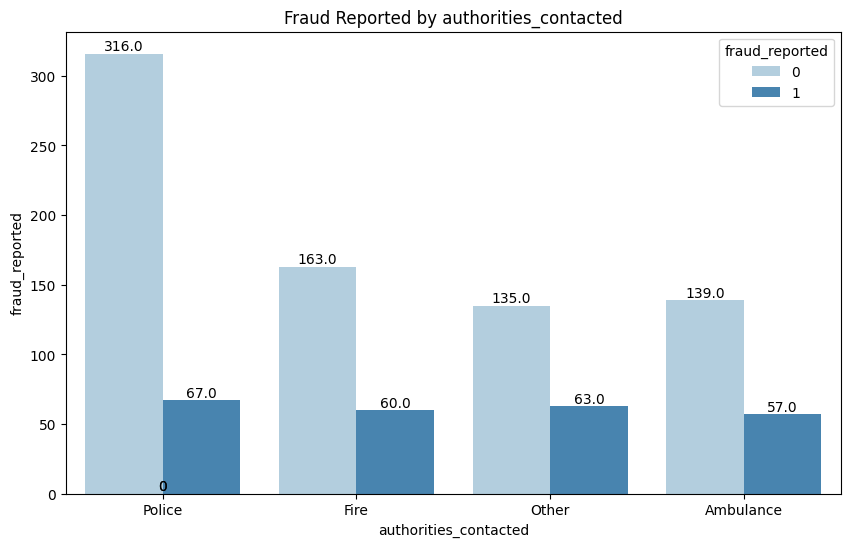

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='authorities_contacted', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by authorities_contacted')
plt.xlabel('authorities_contacted')
plt.ylabel('fraud_reported')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

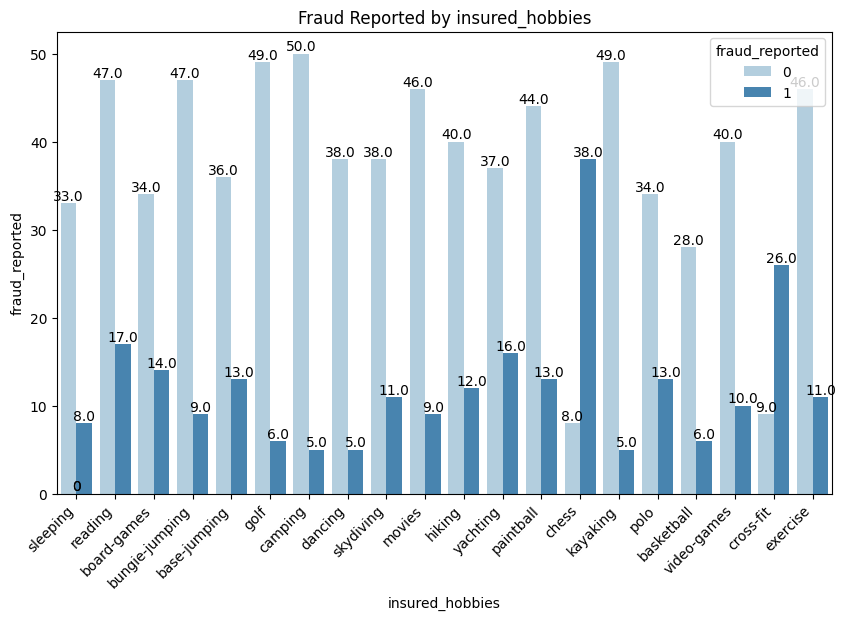

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='insured_hobbies', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by insured_hobbies')
plt.xlabel('insured_hobbies')
plt.ylabel('fraud_reported')

plt.xticks(rotation=45, ha='right')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

Satu hal yang mencolok dalam grafik ini adalah orang-orang yang hobi bermain catur dan cross-fit memiliki jumlah klaim penipuan yang sangat tinggi.

Kami akan menyimpannya dan mengganti nama nilai lainnya sebagai 'other'

In [ ]:
hobbies = df['insured_hobbies'].unique()
for hobby in hobbies:
  if (hobby != 'chess') & (hobby != 'cross-fit'):
    df['insured_hobbies'] = df['insured_hobbies'].str.replace(hobby, 'other')

df['insured_hobbies'].unique()

array(['other', 'chess', 'cross-fit'], dtype=object)

In [ ]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,1000,1406.91,0,466132,MALE,MD,craft-repair,other,husband,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,342868,2006-06-27,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,other,other-relative,0,0,Vehicle Theft,Rear Collision,Minor Damage,Police,8,1,NO,0,0,NO,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,687698,2000-09-06,2000,1413.14,5000000,430632,FEMALE,PhD,sales,other,own-child,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,227811,1990-05-25,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,other,unmarried,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,Police,5,1,NO,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,367455,2014-06-06,1000,1583.91,6000000,610706,MALE,Associate,sales,other,unmarried,66000,-46000,Vehicle Theft,Rear Collision,Minor Damage,Police,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,0


In [ ]:
import plotly.express as px # Import the library and assign it to the alias 'px'

fig = px.histogram(df, x='age', title='Distribution of age', color_discrete_sequence=['blue'])

# Menampilkan grafik
fig.show()

Kami akan mengelompokkan data usia ke dalam beberapa kategori untuk menganalisis tren laporan penipuan (fraud) dan non-penipuan berdasarkan kelompok usia. Pendekatan ini memungkinkan kami untuk mengidentifikasi pola tertentu dalam hubungan antara kelompok usia dan kejadian penipuan, sehingga dapat memberikan wawasan yang lebih mendalam untuk deteksi dan pencegahan penipuan.

In [ ]:
df['age'].describe()

,age
count,1000.000000
mean,38.948000
std,9.140287
min,19.000000
25%,32.000000
50%,38.000000
75%,44.000000
max,64.000000


In [ ]:
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]

df['age_group'] = pd.cut(df['age'], bins = bins, labels = bin_labels, include_lowest = True)

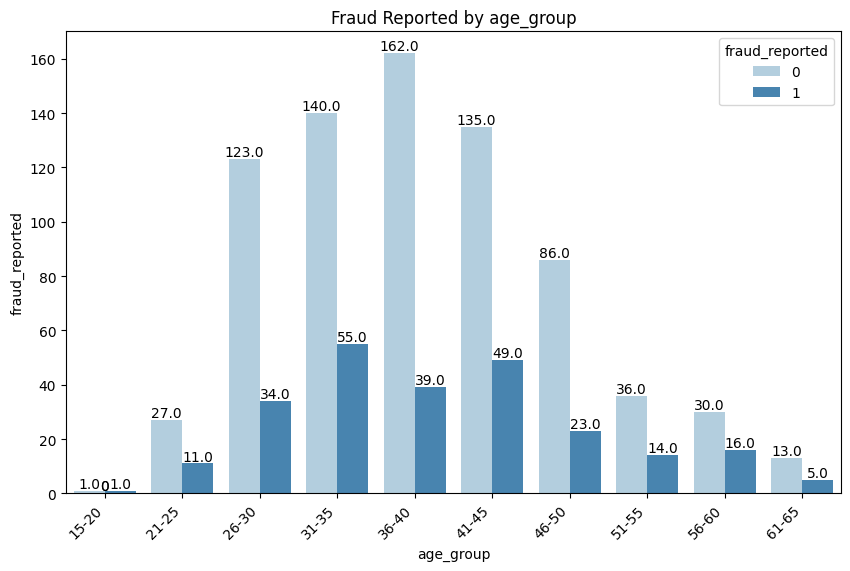

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by age_group')
plt.xlabel('age_group')
plt.ylabel('fraud_reported')

plt.xticks(rotation=45, ha='right')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

Orang-orang yang berada pada kelompok umur 31-35 tahun dan 41-45 tahun memiliki angka penipuan yang lebih tinggi

In [ ]:
fig = px.histogram(df, x='months_as_customer', title='Distribution of months_as_customer', color_discrete_sequence=['blue'])

# Menampilkan grafik
fig.show()

Seperti yang kita lakukan untuk kolom usia, kita akan membuat kolom baru yang mengelompokkan data kolom months_as_customer.

In [ ]:
df['months_as_customer'].describe()

,months_as_customer
count,1000.000000
mean,203.954000
std,115.113174
min,0.000000
25%,115.750000
50%,199.500000
75%,276.250000
max,479.000000


In [ ]:
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']

df['months_as_customer_groups'] = pd.cut(df['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)

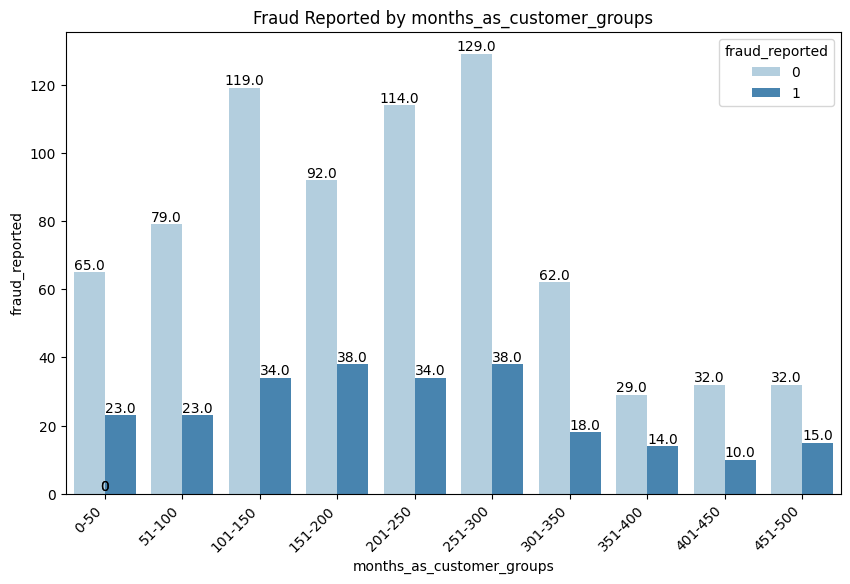

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='months_as_customer_groups', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by months_as_customer_groups')
plt.xlabel('months_as_customer_groups')
plt.ylabel('fraud_reported')

plt.xticks(rotation=45, ha='right')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

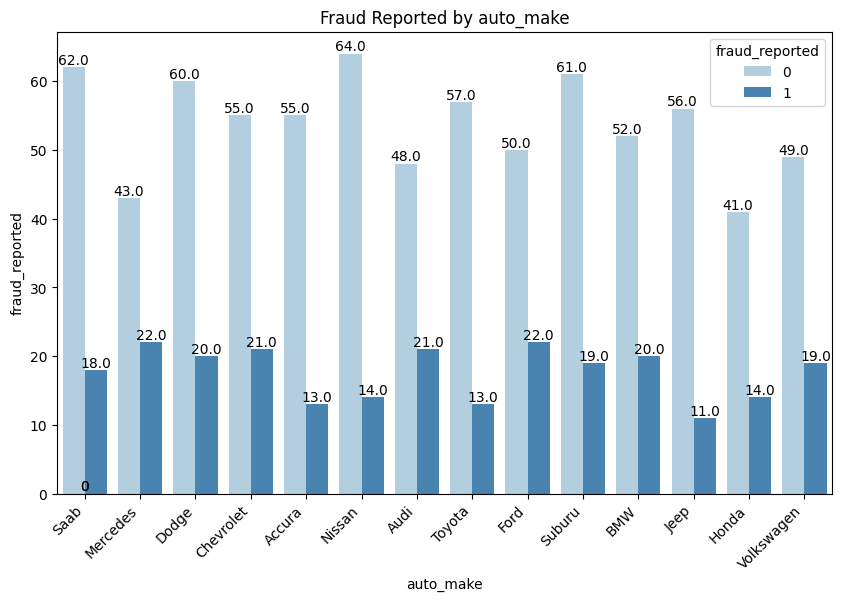

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='auto_make', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by auto_make')
plt.xlabel('auto_make')
plt.ylabel('fraud_reported')

plt.xticks(rotation=45, ha='right')
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

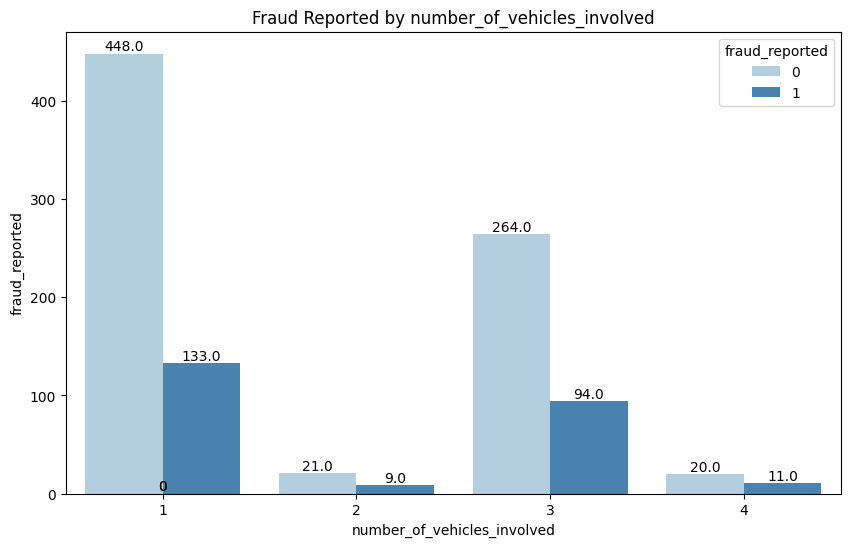

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='number_of_vehicles_involved', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by number_of_vehicles_involved')
plt.xlabel('number_of_vehicles_involved')
plt.ylabel('fraud_reported')


for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

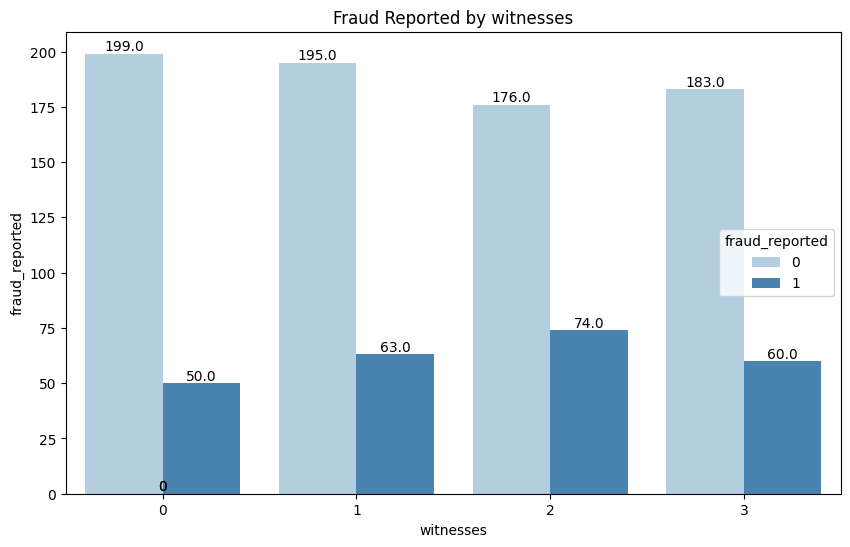

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='witnesses', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by witnesses')
plt.xlabel('witnesses')
plt.ylabel('fraud_reported')


for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

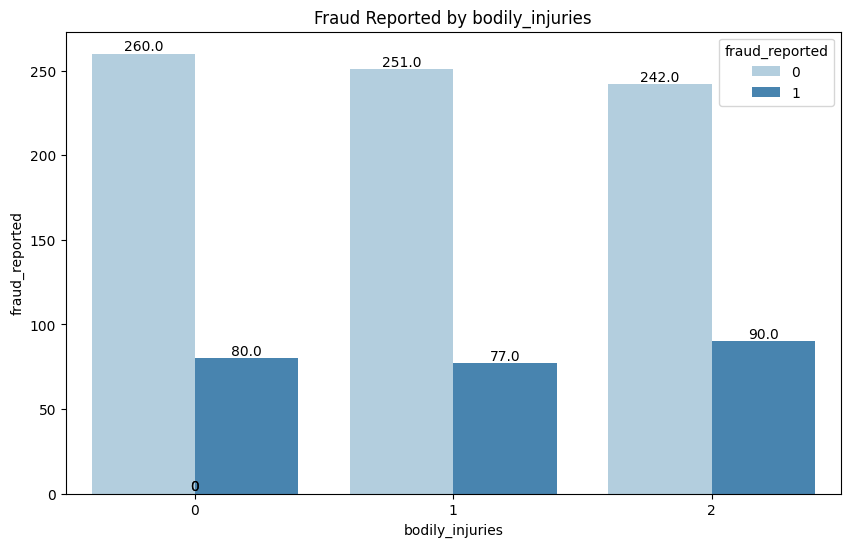

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='bodily_injuries', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by bodily_injuries')
plt.xlabel('bodily_injuries')
plt.ylabel('fraud_reported')


for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

In [ ]:
fig = px.histogram(df, x='total_claim_amount', title='Distribution of total_claim_amount', color_discrete_sequence=['blue'])

# Menampilkan grafik
fig.show()

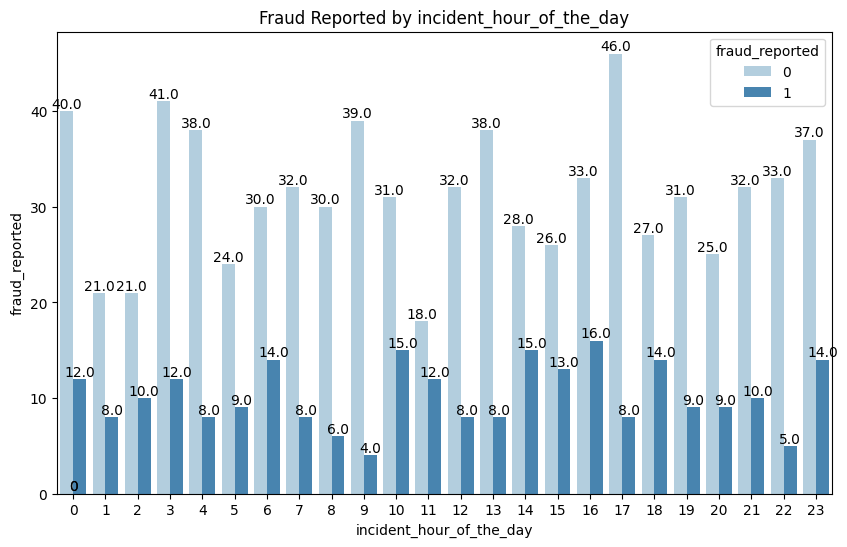

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='incident_hour_of_the_day', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by incident_hour_of_the_day')
plt.xlabel('incident_hour_of_the_day')
plt.ylabel('fraud_reported')


for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

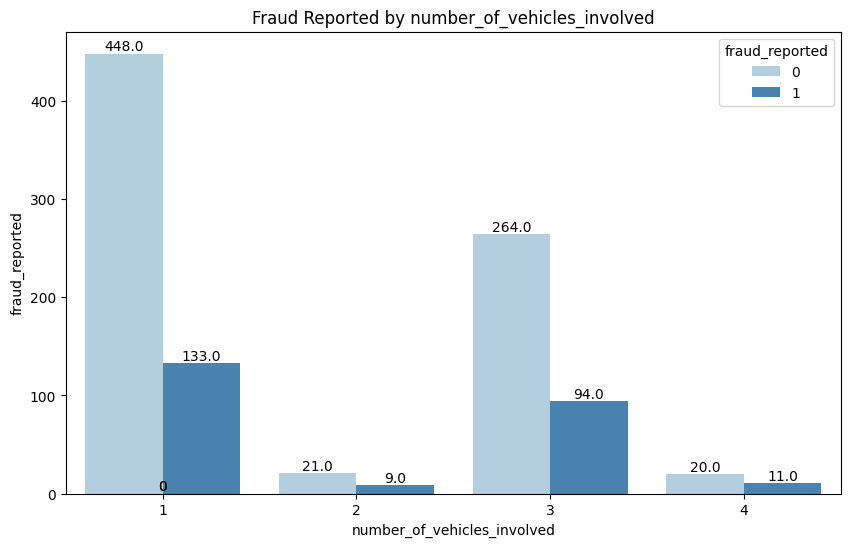

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='number_of_vehicles_involved', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by number_of_vehicles_involved')
plt.xlabel('number_of_vehicles_involved')
plt.ylabel('fraud_reported')


for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

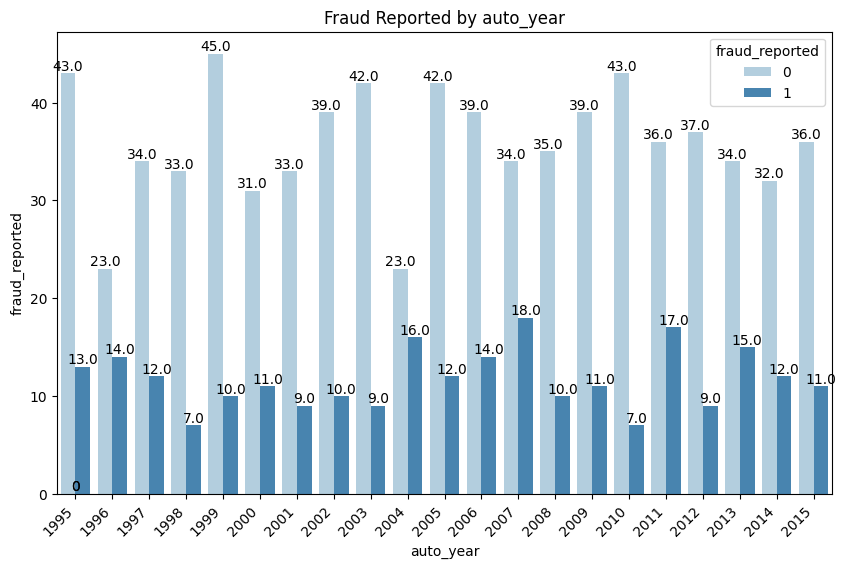

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='auto_year', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by auto_year')
plt.xlabel('auto_year')
plt.ylabel('fraud_reported')

plt.xticks(rotation=45, ha='right')
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

In [ ]:
df['policy_annual_premium'].describe()

,policy_annual_premium
count,1000.000000
mean,1256.406150
std,244.167395
min,433.330000
25%,1089.607500
50%,1257.200000
75%,1415.695000
max,2047.590000


In [ ]:
bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']

df['policy_annual_premium_groups'] = pd.cut(df['policy_annual_premium'], bins = bins, labels=bin_labels)

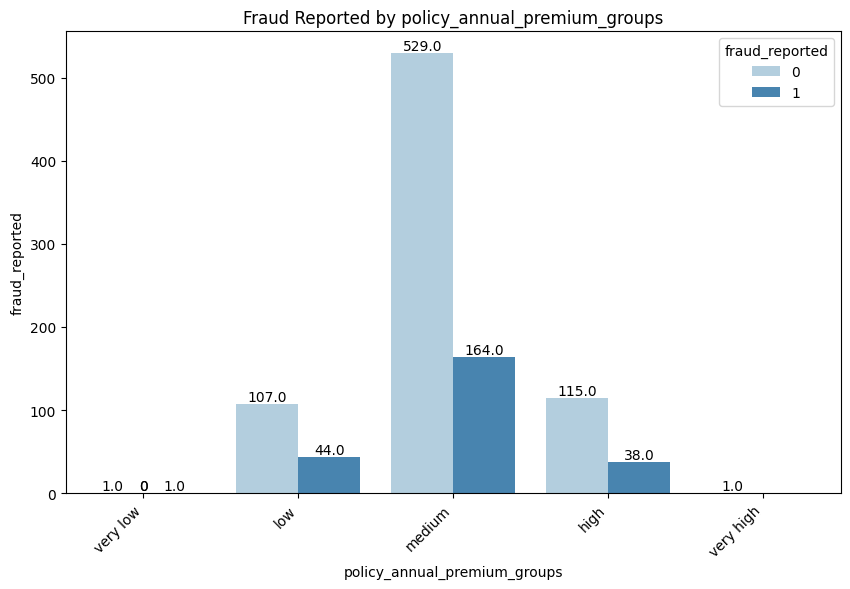

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='policy_annual_premium_groups', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by policy_annual_premium_groups')
plt.xlabel('policy_annual_premium_groups')
plt.ylabel('fraud_reported')

plt.xticks(rotation=45, ha='right')
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

In [ ]:
df['policy_deductable'].describe()

,policy_deductable
count,1000.000000
mean,1136.000000
std,611.864673
min,500.000000
25%,500.000000
50%,1000.000000
75%,2000.000000
max,2000.000000


In [ ]:
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']

df['policy_deductable_group'] = pd.cut(df['policy_deductable'], bins = bins, labels = bin_labels)

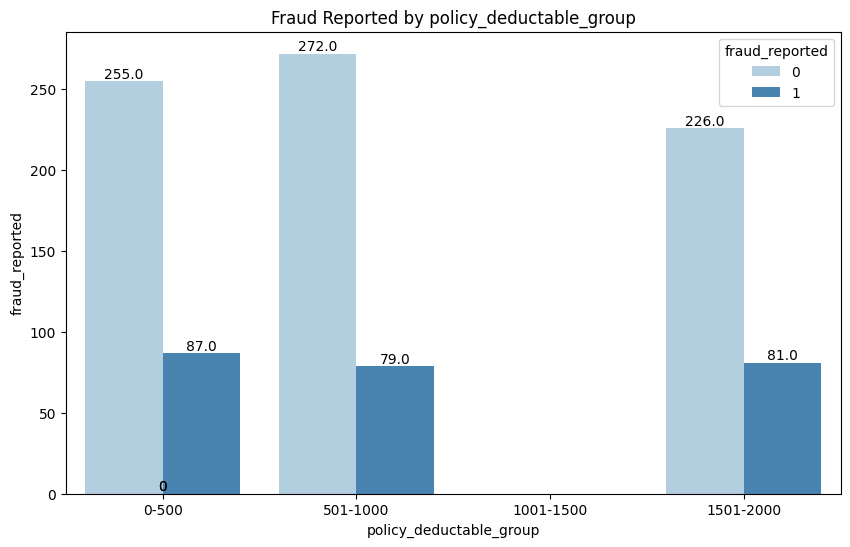

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='policy_deductable_group', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by policy_deductable_group')
plt.xlabel('policy_deductable_group')
plt.ylabel('fraud_reported')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

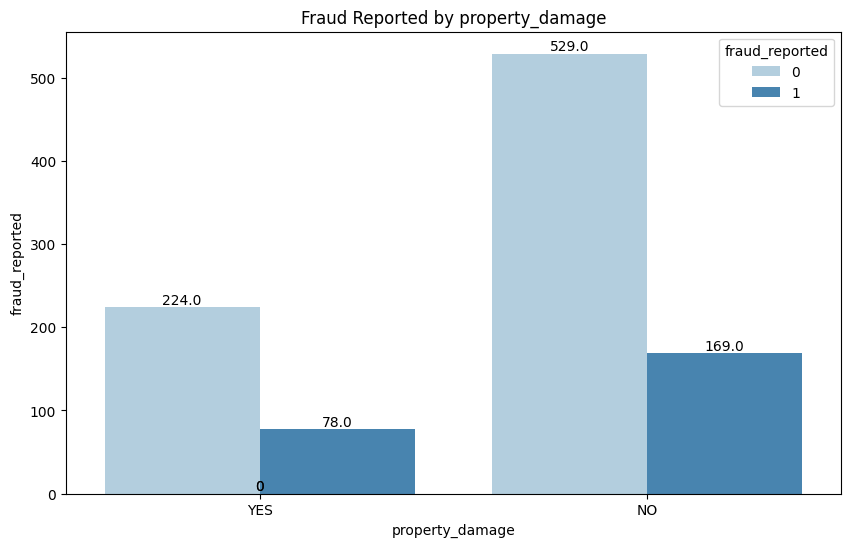

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='property_damage', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by property_damage')
plt.xlabel('property_damage')
plt.ylabel('fraud_reported')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

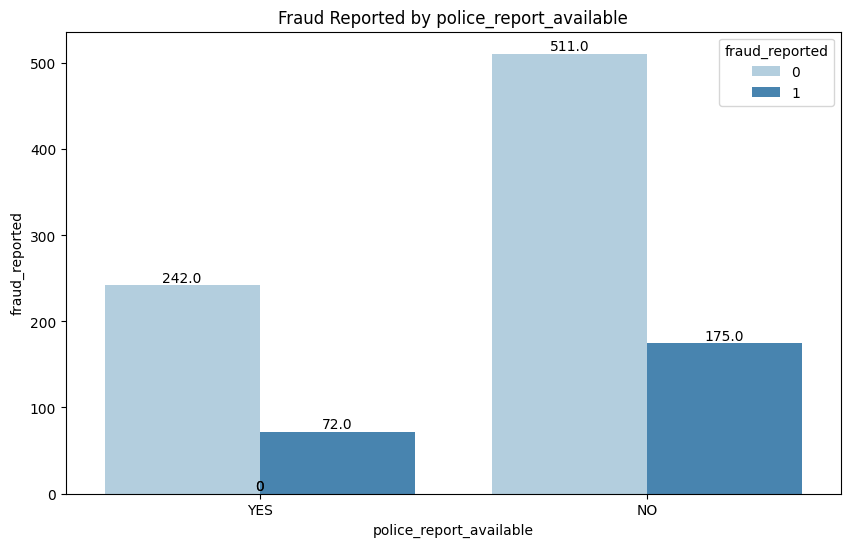

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='police_report_available', hue='fraud_reported', data=df, palette='Blues')
plt.title('Fraud Reported by police_report_available')
plt.xlabel('police_report_available')
plt.ylabel('fraud_reported')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

In [ ]:
#removing columns for which we created groups
df = df.drop(['age', 'months_as_customer', 'policy_deductable', 'policy_annual_premium'], axis = 1)
df.columns

Index(['policy_number', 'policy_bind_date', 'umbrella_limit', 'insured_zip',
       'insured_sex', 'insured_education_level', 'insured_occupation',
       'insured_hobbies', 'insured_relationship', 'capital-gains',
       'capital-loss', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'age_group',
       'months_as_customer_groups', 'policy_annual_premium_groups',
       'policy_deductable_group'],
      dtype='object')

In [ ]:
required_columns = ['policy_number', 'insured_sex', 'insured_education_level', 'insured_occupation',
       'insured_hobbies', 'capital-gains', 'capital-loss', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'witnesses', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim',
       'fraud_reported', 'age_group',
       'months_as_customer_groups', 'policy_annual_premium_groups']

print(len(required_columns))

22


In [ ]:
!pip install plotly
import plotly.graph_objects as go # Import the plotly.graph_objects module and assign it to the alias 'go'

corr_matrix = df.select_dtypes(include=np.number).corr() # Selecting only numeric columns for correlation calculation

fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    text=corr_matrix.values.round(2), # Displaying the correlation values rounded to 2 decimal places
    texttemplate="%{text}" # Formatting the text display
))

fig.update_layout(title='Correlation')

fig.show()

Dari matriks korelasi, kita melihat ada korelasi tinggi antara `vehicle claim`, `total_claim_amount`, `property_claim` and `injury_claim`

Alasannya adalah karena `total_claim_amount` merupakan  vehicle claim`,`property_claim` and `injury_claim`.`

Kita akan menghapus 3 kolom lainnya dan hanya menyimpan `total_claim_amount` karena kolom tersebut memuat informasi dan menghilangkan kolinearitas.

In [ ]:
t = df['total_claim_amount'].iloc[1]
a = df['vehicle_claim'].iloc[1]
b = df['property_claim'].iloc[1]
c = df['injury_claim'].iloc[1]

print(t)
a+b+c

5070


5070

t = df['total_claim_amount'].iloc[1]
a = df['vehicle_claim'].iloc[1]
b = df['property_claim'].iloc[1]
c = df['injury_claim'].iloc[1]

print(t)
a+b+c

In [ ]:
required_columns = ['insured_sex', 'insured_occupation',
       'insured_hobbies', 'capital-gains', 'capital-loss', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'witnesses', 'total_claim_amount', 'fraud_reported', 'age_group',
       'months_as_customer_groups', 'policy_annual_premium_groups']

print(len(required_columns))

17


In [ ]:
df = df[required_columns]
df.head()

,insured_sex,insured_occupation,insured_hobbies,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_hour_of_the_day,number_of_vehicles_involved,witnesses,total_claim_amount,fraud_reported,age_group,months_as_customer_groups,policy_annual_premium_groups
0,MALE,craft-repair,other,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,5,1,2,71610,1,46-50,301-350,medium
1,MALE,machine-op-inspct,other,0,0,Vehicle Theft,Rear Collision,Minor Damage,Police,8,1,0,5070,1,41-45,201-250,medium
2,FEMALE,sales,other,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,7,3,3,34650,0,26-30,101-150,medium
3,FEMALE,armed-forces,other,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,Police,5,1,2,63400,1,41-45,251-300,medium
4,MALE,sales,other,66000,-46000,Vehicle Theft,Rear Collision,Minor Damage,Police,20,1,1,6500,0,41-45,201-250,high


In [ ]:
df['fraud_reported'] = df['fraud_reported'].replace(-1, 0)
df['fraud_reported'].value_counts()

,count
fraud_reported,
0,753
1,247


In [ ]:
# prompt: VIF SCORe

# Assuming 'df' is your DataFrame and 'required_columns' is defined as in your provided code.

# Select only the numeric columns for VIF calculation
numeric_cols = df.select_dtypes(include=np.number).columns

# Add a constant to the numeric features
X = add_constant(df[numeric_cols])

# Calculate VIF for each numeric feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]

# Display the VIF scores
vif_data

,feature,VIF
0,const,11.324147
1,capital-gains,1.007470
2,capital-loss,1.005697
3,incident_hour_of_the_day,1.056530
4,number_of_vehicles_involved,1.090302
5,witnesses,1.005140
6,total_claim_amount,1.153772
7,fraud_reported,1.032140


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming 'df' is your DataFrame and relevant columns are already processed.

# Example: Perform Chi-Square test for independence between 'insured_occupation' and 'fraud_reported'
contingency_table = pd.crosstab(df['insured_occupation'], df['fraud_reported'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:\n", expected)

# Interpret the results (example threshold of 0.05)
alpha = 0.05
if p < alpha:
  print("There is a significant association between insured occupation and fraud reported.")
else:
  print("There is no significant association between insured occupation and fraud reported.")

# Repeat this process for other categorical variables you want to test against 'fraud_reported'.
# Example for 'incident_type'
contingency_table = pd.crosstab(df['incident_type'], df['fraud_reported'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square statistic for incident_type: {chi2}")
print(f"P-value for incident_type: {p}")
print(f"Degrees of freedom for incident_type: {dof}")
print("Expected frequencies for incident_type:\n", expected)

if p < alpha:
  print("There is a significant association between incident type and fraud reported.")
else:
  print("There is no significant association between incident type and fraud reported.")

Chi-square statistic: 17.659340491516012
P-value: 0.17088761164902544
Degrees of freedom: 13
Expected frequencies:
 [[48.945 16.055]
 [51.957 17.043]
 [55.722 18.278]
 [57.228 18.772]
 [39.909 13.091]
 [40.662 13.338]
 [70.029 22.971]
 [53.463 17.537]
 [53.463 17.537]
 [64.005 20.995]
 [47.439 15.561]
 [57.228 18.772]
 [58.734 19.266]
 [54.216 17.784]]
There is no significant association between insured occupation and fraud reported.

Chi-square statistic for incident_type: 29.131539725752873
P-value for incident_type: 2.1013336774786627e-06
Degrees of freedom for incident_type: 3
Expected frequencies for incident_type:
 [[315.507 103.493]
 [ 63.252  20.748]
 [303.459  99.541]
 [ 70.782  23.218]]
There is a significant association between incident type and fraud reported.


##Encoding

In [ ]:
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups']
for col in cat_cols:
  df[col] = df[col].astype('object')

columns_to_encode = []
for col in df.columns:
  if df[col].dtype == 'object':
    columns_to_encode.append(col)

columns_to_encode

['insured_sex',
 'insured_occupation',
 'insured_hobbies',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'age_group',
 'months_as_customer_groups',
 'policy_annual_premium_groups']

In [ ]:
df[['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups']].head()

,age_group,months_as_customer_groups,policy_annual_premium_groups
0,46-50,301-350,medium
1,41-45,201-250,medium
2,26-30,101-150,medium
3,41-45,251-300,medium
4,41-45,201-250,high


In [ ]:
df.head()

,insured_sex,insured_occupation,insured_hobbies,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_hour_of_the_day,number_of_vehicles_involved,witnesses,total_claim_amount,fraud_reported,age_group,months_as_customer_groups,policy_annual_premium_groups
0,MALE,craft-repair,other,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,5,1,2,71610,1,46-50,301-350,medium
1,MALE,machine-op-inspct,other,0,0,Vehicle Theft,Rear Collision,Minor Damage,Police,8,1,0,5070,1,41-45,201-250,medium
2,FEMALE,sales,other,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,7,3,3,34650,0,26-30,101-150,medium
3,FEMALE,armed-forces,other,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,Police,5,1,2,63400,1,41-45,251-300,medium
4,MALE,sales,other,66000,-46000,Vehicle Theft,Rear Collision,Minor Damage,Police,20,1,1,6500,0,41-45,201-250,high


In [ ]:
df1 = pd.get_dummies(df, columns = columns_to_encode)

df1.head()

,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,witnesses,total_claim_amount,fraud_reported,insured_sex_FEMALE,insured_sex_MALE,insured_occupation_adm-clerical,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_other,incident_type_Multi-vehicle Collision,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_Front Collision,collision_type_Rear Collision,collision_type_Side Collision,incident_severity_Major Damage,incident_severity_Minor Damage,incident_severity_Total Loss,incident_severity_Trivial Damage,authorities_contacted_Ambulance,authorities_contacted_Fire,authorities_contacted_Other,authorities_contacted_Police,age_group_15-20,age_group_21-25,age_group_26-30,age_group_31-35,age_group_36-40,age_group_41-45,age_group_46-50,age_group_51-55,age_group_56-60,age_group_61-65,months_as_customer_groups_0-50,months_as_customer_groups_101-150,months_as_customer_groups_151-200,months_as_customer_groups_201-250,months_as_customer_groups_251-300,months_as_customer_groups_301-350,months_as_customer_groups_351-400,months_as_customer_groups_401-450,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low
0,53300,0,5,1,2,71610,1,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
1,0,0,8,1,0,5070,1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
2,35100,0,7,3,3,34650,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False
3,48900,-62400,5,1,2,63400,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
4,66000,-46000,20,1,1,6500,0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False


# Target

In [ ]:
features = []
for col in df1.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X = df1[features]
y = df1[target]

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

# Split train, val, test

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

#smote


In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class distribution before SMOTE:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

Class distribution before SMOTE:
fraud_reported
0    452
1    148
Name: count, dtype: int64

Class distribution after SMOTE:
fraud_reported
0    452
1    452
Name: count, dtype: int64


#cross Validation

In [ ]:
!pip install scikit-learn==1.3.0 xgboost==1.7.2

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Definisikan model
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Cross-Validation
cv_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
    cv_results[model_name] = scores
    print(f"{model_name} Cross-Validation Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

# finding best model based on average accuracy
best_model_name = max(cv_results, key=lambda k: cv_results[k].mean())
print(f"\nBest Model: {best_model_name}")


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



Logistic Regression Cross-Validation Accuracy: 0.8717 (+/- 0.0161)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



XGBoost Cross-Validation Accuracy: 0.8906 (+/- 0.0639)
Decision Tree Cross-Validation Accuracy: 0.8607 (+/- 0.0578)
Naive Bayes Cross-Validation Accuracy: 0.7534 (+/- 0.0758)
SVM Cross-Validation Accuracy: 0.8938 (+/- 0.0185)
Random Forest Cross-Validation Accuracy: 0.8939 (+/- 0.0594)

Best Model: Random Forest


##MODELING

In [ ]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_smote, y_train_smote)  # Fit model

# Predict on validation data and test data
y_val_pred_logreg = logreg.predict(X_val)
y_test_pred_logreg = logreg.predict(X_test)

# Display classification report for validation data
print("\nLogistic Regression - Validation Data:")
print(classification_report(y_val, y_val_pred_logreg))

# Display classification report for test data
print("\nLogistic Regression - Test Data:")
print(classification_report(y_test, y_test_pred_logreg))


Logistic Regression - Validation Data:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       155
           1       0.63      0.73      0.68        45

    accuracy                           0.84       200
   macro avg       0.78      0.81      0.79       200
weighted avg       0.85      0.84      0.85       200


Logistic Regression - Test Data:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       146
           1       0.69      0.78      0.73        54

    accuracy                           0.84       200
   macro avg       0.80      0.82      0.81       200
weighted avg       0.85      0.84      0.85       200



In [ ]:
# XGBoost
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_clf.fit(X_train_smote, y_train_smote)

# Predict on validation and test data
y_val_pred_xgb = xgb_clf.predict(X_val)
y_test_pred_xgb = xgb_clf.predict(X_test)

# Classification report
print("XGBoost - Validation Data:")
print(classification_report(y_val, y_val_pred_xgb))

print("\nXGBoost - Test Data:")
print(classification_report(y_test, y_test_pred_xgb))


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



XGBoost - Validation Data:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       155
           1       0.60      0.53      0.56        45

    accuracy                           0.81       200
   macro avg       0.73      0.72      0.72       200
weighted avg       0.81      0.81      0.81       200


XGBoost - Test Data:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       146
           1       0.71      0.67      0.69        54

    accuracy                           0.83       200
   macro avg       0.79      0.78      0.79       200
weighted avg       0.83      0.83      0.83       200



In [ ]:
# Decision Tree
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train_smote, y_train_smote)

# Predict on validation and test data
y_val_pred_dtc = dtc.predict(X_val)
y_test_pred_dtc = dtc.predict(X_test)

# Classification report
print("Decision Tree - Validation Data:")
print(classification_report(y_val, y_val_pred_dtc))

print("\nDecision Tree - Test Data:")
print(classification_report(y_test, y_test_pred_dtc))


Decision Tree - Validation Data:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       155
           1       0.53      0.53      0.53        45

    accuracy                           0.79       200
   macro avg       0.70      0.70      0.70       200
weighted avg       0.79      0.79      0.79       200


Decision Tree - Test Data:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       146
           1       0.56      0.50      0.53        54

    accuracy                           0.76       200
   macro avg       0.69      0.68      0.68       200
weighted avg       0.75      0.76      0.76       200



In [ ]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train_smote, y_train_smote)

# Predict on validation and test data
y_val_pred_nb = nb.predict(X_val)
y_test_pred_nb = nb.predict(X_test)

# Classification report
print("Naive Bayes - Validation Data:")
print(classification_report(y_val, y_val_pred_nb))

print("\nNaive Bayes - Test Data:")
print(classification_report(y_test, y_test_pred_nb))


Naive Bayes - Validation Data:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       155
           1       0.40      0.56      0.46        45

    accuracy                           0.71       200
   macro avg       0.63      0.66      0.63       200
weighted avg       0.75      0.71      0.73       200


Naive Bayes - Test Data:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       146
           1       0.49      0.65      0.56        54

    accuracy                           0.72       200
   macro avg       0.67      0.70      0.68       200
weighted avg       0.75      0.72      0.73       200



In [ ]:
# SVM
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_smote, y_train_smote)

# Predict on validation and test data
y_val_pred_svm = svm.predict(X_val)
y_test_pred_svm = svm.predict(X_test)

# Classification report
print("SVM - Validation Data:")
print(classification_report(y_val, y_val_pred_svm))

print("\nSVM - Test Data:")
print(classification_report(y_test, y_test_pred_svm))


SVM - Validation Data:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       155
           1       0.62      0.76      0.68        45

    accuracy                           0.84       200
   macro avg       0.77      0.81      0.79       200
weighted avg       0.86      0.84      0.85       200


SVM - Test Data:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       146
           1       0.69      0.78      0.73        54

    accuracy                           0.84       200
   macro avg       0.80      0.82      0.81       200
weighted avg       0.85      0.84      0.85       200



In [ ]:
# Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_smote, y_train_smote)

# Predict on validation and test data
y_val_pred_rf = rf_clf.predict(X_val)
y_test_pred_rf = rf_clf.predict(X_test)

# Classification report
print("Random Forest - Validation Data:")
print(classification_report(y_val, y_val_pred_rf))

print("\nRandom Forest - Test Data:")
print(classification_report(y_test, y_test_pred_rf))


Random Forest - Validation Data:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       155
           1       0.60      0.60      0.60        45

    accuracy                           0.82       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.82      0.82      0.82       200


Random Forest - Test Data:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       146
           1       0.69      0.69      0.69        54

    accuracy                           0.83       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.83      0.83      0.83       200



In [ ]:
logreg_report = classification_report(y_test, y_test_pred_logreg, output_dict=True)
xgb_report = classification_report(y_test, y_test_pred_xgb, output_dict=True)
dt_report = classification_report(y_test, y_test_pred_dtc, output_dict=True)
nb_report = classification_report(y_test, y_test_pred_nb, output_dict=True)
svm_report = classification_report(y_test, y_test_pred_svm, output_dict=True)
rf_report = classification_report(y_test, y_test_pred_rf, output_dict=True)

In [ ]:
from sklearn.metrics import accuracy_score

# Menghitung accuracy untuk setiap model
accuracy_logreg = accuracy_score(y_test, y_test_pred_logreg)
accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
accuracy_dt = accuracy_score(y_test, y_test_pred_dtc)
accuracy_nb = accuracy_score(y_test, y_test_pred_nb)
accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

# Menambahkan accuracy ke dalam dictionary metrics
metrics = {
    "Model": ["Logistic Regression", "XGBoost", "Decision Trees", "Naive Bayes", "SVM", "Random Forest"],
    "Precision (0)": [
        logreg_report['0']['precision'],
        xgb_report['0']['precision'],
        dt_report['0']['precision'],
        nb_report['0']['precision'],
        svm_report['0']['precision'],
        rf_report['0']['precision']
    ],
    "Recall (0)": [
        logreg_report['0']['recall'],
        xgb_report['0']['recall'],
        dt_report['0']['recall'],
        nb_report['0']['recall'],
        svm_report['0']['recall'],
        rf_report['0']['recall']
    ],
    "F1-Score (0)": [
        logreg_report['0']['f1-score'],
        xgb_report['0']['f1-score'],
        dt_report['0']['f1-score'],
        nb_report['0']['f1-score'],
        svm_report['0']['f1-score'],
        rf_report['0']['f1-score']
    ],
    "Precision (1)": [
        logreg_report['1']['precision'],
        xgb_report['1']['precision'],
        dt_report['1']['precision'],
        nb_report['1']['precision'],
        svm_report['1']['precision'],
        rf_report['1']['precision']
    ],
    "Recall (1)": [
        logreg_report['1']['recall'],
        xgb_report['1']['recall'],
        dt_report['1']['recall'],
        nb_report['1']['recall'],
        svm_report['1']['recall'],
        rf_report['1']['recall']
    ],
    "F1-Score (1)": [
        logreg_report['1']['f1-score'],
        xgb_report['1']['f1-score'],
        dt_report['1']['f1-score'],
        nb_report['1']['f1-score'],
        svm_report['1']['f1-score'],
        rf_report['1']['f1-score']
    ],
    "Accuracy": [
        accuracy_logreg,
        accuracy_xgb,
        accuracy_dt,
        accuracy_nb,
        accuracy_svm,
        accuracy_rf
    ]
}

# Membuat DataFrame
results = pd.DataFrame(metrics)

# Menampilkan hasil
results


,Model,Precision (0),Recall (0),F1-Score (0),Precision (1),Recall (1),F1-Score (1),Accuracy
0,Logistic Regression,0.913669,0.869863,0.891228,0.688525,0.777778,0.730435,0.845
1,XGBoost,0.879195,0.897260,0.888136,0.705882,0.666667,0.685714,0.835
2,Decision Trees,0.822368,0.856164,0.838926,0.562500,0.500000,0.529412,0.760
3,Naive Bayes,0.851562,0.746575,0.795620,0.486111,0.648148,0.555556,0.720
4,SVM,0.913669,0.869863,0.891228,0.688525,0.777778,0.730435,0.845
5,Random Forest,0.883562,0.883562,0.883562,0.685185,0.685185,0.685185,0.830


Logistic Regression dan SVM adalah model terbaik berdasarkan metrik:

Precision, Recall, dan F1-Score di kedua kelas (0 dan 1) cukup tinggi dan seimbang.
Accuracy tertinggi: 0.845.
XGBoost adalah pilihan yang baik jika fokusnya adalah Recall untuk kelas 0, tetapi performa untuk kelas 1 lebih rendah dibanding Logistic Regression dan SVM.

Model seperti Decision Trees, Naive Bayes, dan Random Forest memiliki performa yang lebih rendah dibandingkan model lainnya.

Rekomendasi: Gunakan Logistic Regression atau SVM, karena keduanya memiliki performa konsisten dan metrik keseluruhan yang unggul.

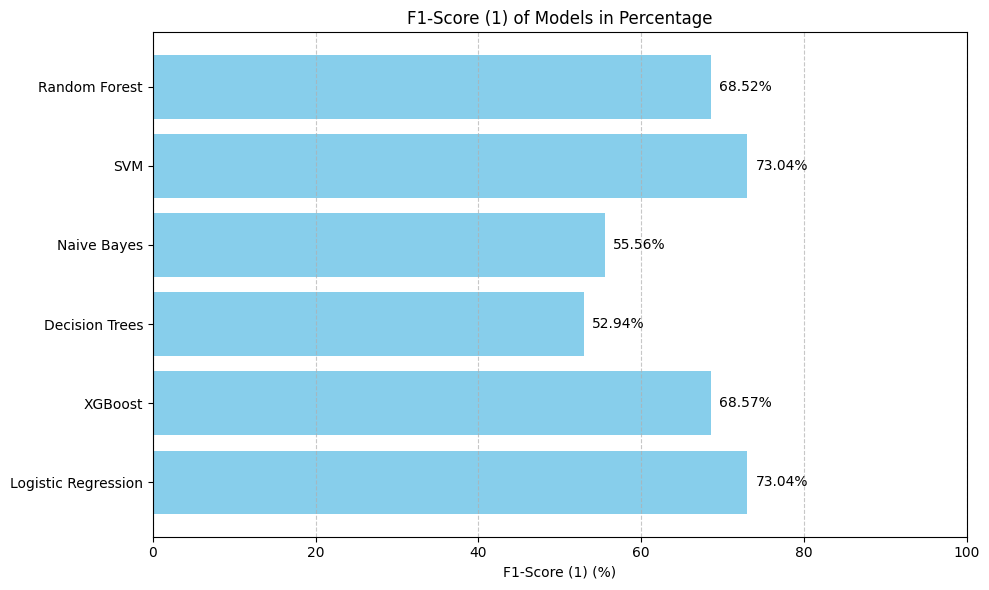

In [ ]:
# Plotting the barplot for F1-Score (1)
plt.figure(figsize=(10, 6))
bars = plt.barh(results["Model"], results["F1-Score (1)"] * 100, color="skyblue")  # Menggunakan F1-Score (1)
plt.xlabel("F1-Score (1) (%)")  # Mengubah label sumbu x
plt.title("F1-Score (1) of Models in Percentage")  # Mengubah judul
plt.xlim(0, 100)  # Set limit to represent percentage scale
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Add percentage values at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.2f}%',
             va='center', ha='left', color='black')

plt.tight_layout()
plt.show()

##model Evaluate

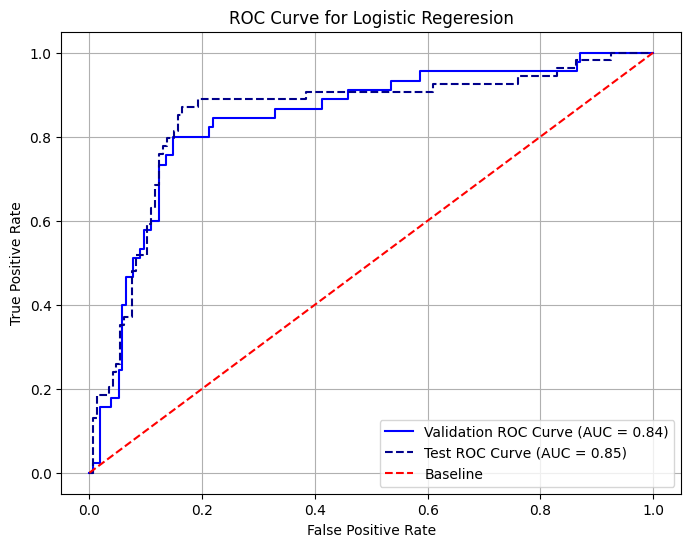

In [ ]:
from sklearn.metrics import roc_curve, auc
# --- SVM ---
# Get predicted probabilities for the positive class
y_val_prob_logreg = logreg.predict_proba(X_val)[:, 1]
y_test_prob_logreg = logreg.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC score for validation and test sets
fpr_val_logreg, tpr_val_logreg, _ = roc_curve(y_val, y_val_prob_logreg)
roc_auc_val_logreg = auc(fpr_val_logreg, tpr_val_logreg)

fpr_test_logreg, tpr_test_logreg, _ = roc_curve(y_test, y_test_prob_logreg)
roc_auc_test_logreg = auc(fpr_test_logreg, tpr_test_logreg)

# --- Plot ROC Curves for Logistic Regression ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_val_logreg, tpr_val_logreg, color='blue',
         label=f'Validation ROC Curve (AUC = {roc_auc_val_logreg:.2f})')
plt.plot(fpr_test_logreg, tpr_test_logreg, color='darkblue', linestyle='--',
         label=f'Test ROC Curve (AUC = {roc_auc_test_logreg:.2f})')

# Baseline
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Baseline')

plt.title('ROC Curve for Logistic Regeresion')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

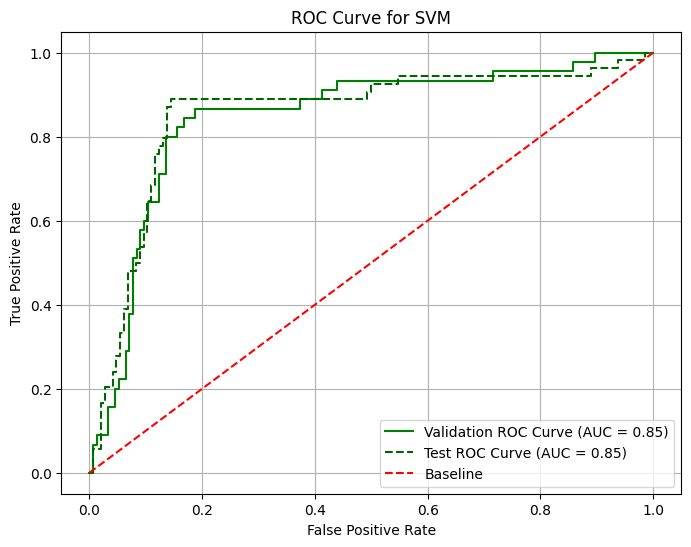

In [ ]:
from sklearn.metrics import roc_curve, auc
# --- SVM ---
# Get predicted probabilities for the positive class
y_val_prob_svm = svm.predict_proba(X_val)[:, 1]
y_test_prob_svm = svm.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC score for validation and test sets
fpr_val_svm, tpr_val_svm, _ = roc_curve(y_val, y_val_prob_svm)
roc_auc_val_svm = auc(fpr_val_svm, tpr_val_svm)

fpr_test_svm, tpr_test_svm, _ = roc_curve(y_test, y_test_prob_svm)
roc_auc_test_svm = auc(fpr_test_svm, tpr_test_svm)

# --- Plot ROC Curves for SVM ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_val_svm, tpr_val_svm, color='green',
         label=f'Validation ROC Curve (AUC = {roc_auc_val_svm:.2f})')
plt.plot(fpr_test_svm, tpr_test_svm, color='darkgreen', linestyle='--',
         label=f'Test ROC Curve (AUC = {roc_auc_test_svm:.2f})')

# Baseline
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Baseline')

plt.title('ROC Curve for SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


ROC curve menggambarkan hubungan antara:

True Positive Rate (TPR) atau Sensitivitas (sumbu y): Proporsi prediksi benar untuk kelas positif (contoh: pengiriman terlambat diprediksi dengan benar).
False Positive Rate (FPR) (sumbu x): Proporsi prediksi salah untuk kelas negatif (contoh: pengiriman tidak terlambat diprediksi sebagai terlambat).
Semakin mendekati kurva ke sudut kiri atas, semakin baik performa model.

Model yang diuji menunjukkan performa yang stabil antara data validasi (AUC = 0.85) dan data pengujian (AUC = 0.85).
Performa model sangat baik dan konsisten, menunjukkan kemampuan yang kuat dalam membedakan kelas positif dan negatif. Meski demikian, model dapat lebih ditingkatkan dengan optimasi parameter atau mencoba metode tambahan.

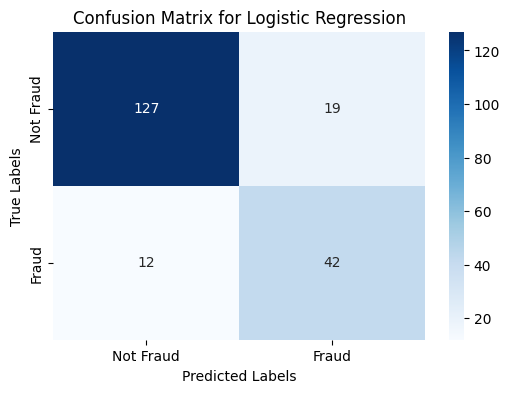

In [ ]:
conf_matrix_logreg = confusion_matrix(y_test, y_test_pred_logreg)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

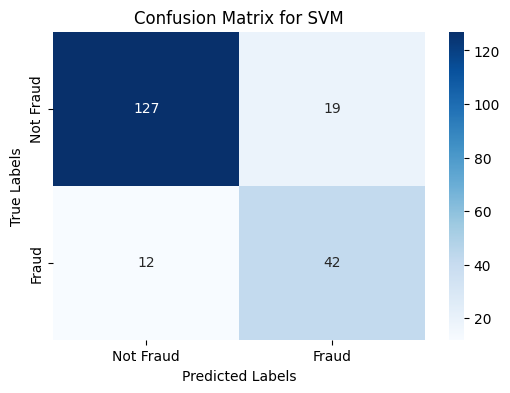

In [ ]:
conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

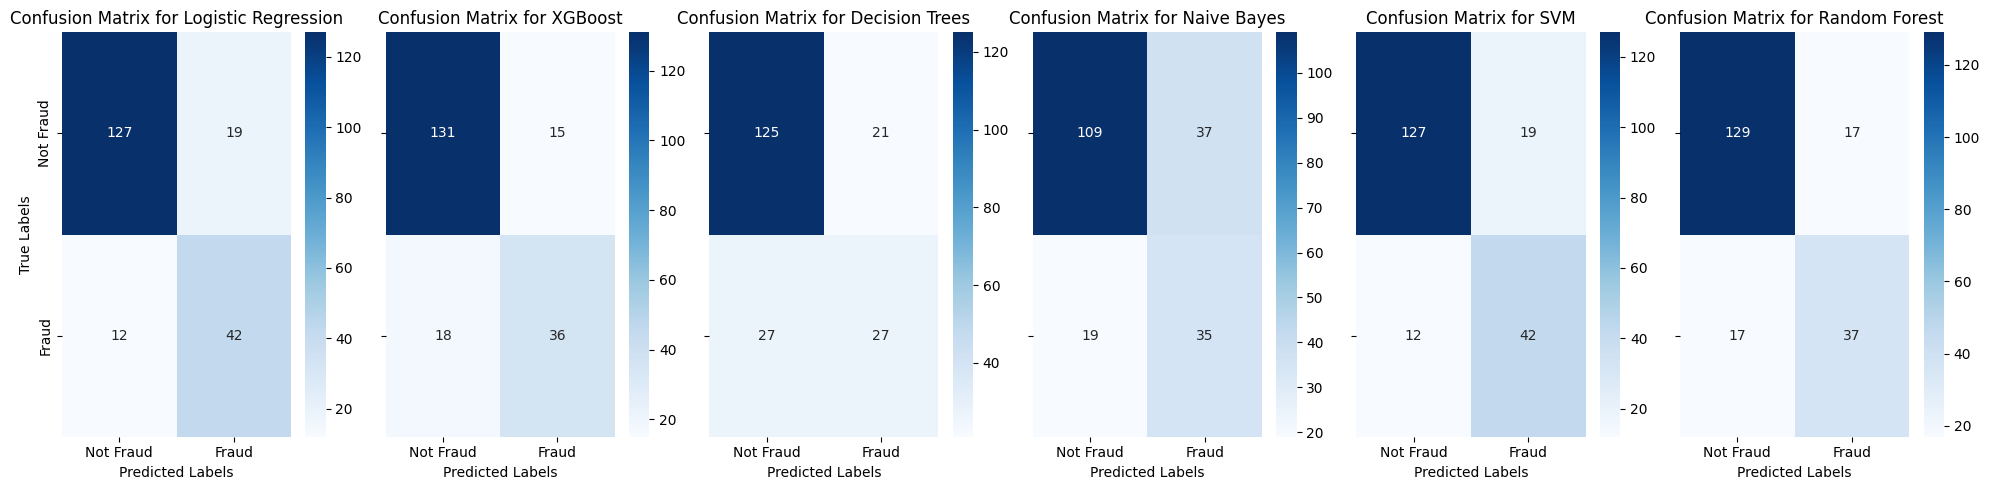

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Models and their predictions
models = {
    "Logistic Regression": y_test_pred_logreg,
    "XGBoost": y_test_pred_xgb,
    "Decision Trees": y_test_pred_dtc,
    "Naive Bayes": y_test_pred_nb,
    "SVM": y_test_pred_svm,
    "Random Forest": y_test_pred_rf
}

# Create subplots
fig, axes = plt.subplots(1, len(models), figsize=(20, 5), sharey=True)  # 1 row, n columns

# Plot confusion matrices in subplots
for i, (model_name, y_pred) in enumerate(models.items()):
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'],
                ax=axes[i])  # Plot on the current subplot
    axes[i].set_title(f'Confusion Matrix for {model_name}')
    axes[i].set_xlabel('Predicted Labels')
    if i == 0:  # Only set ylabel for the first subplot
        axes[i].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

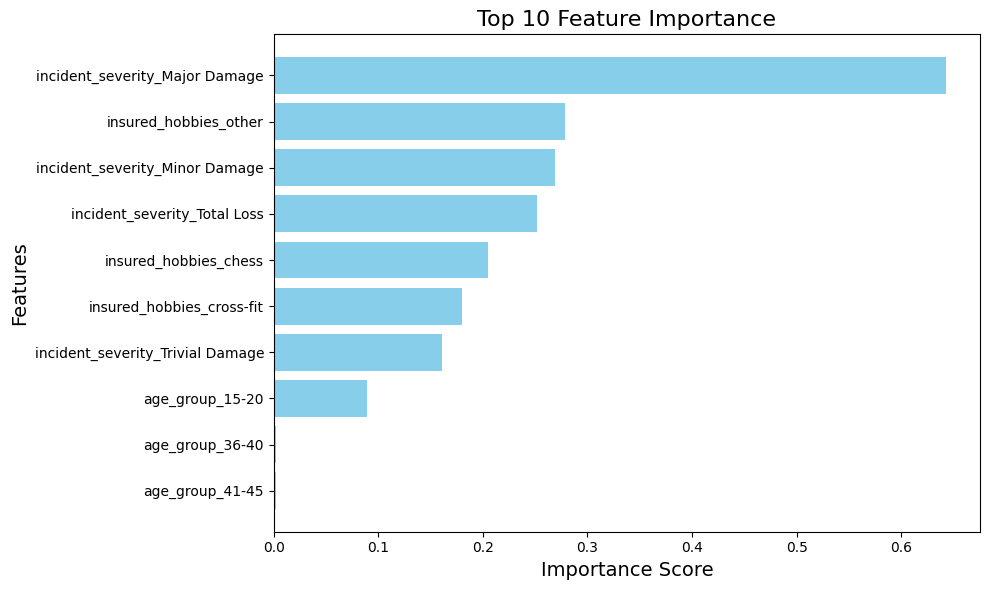

In [ ]:
# Assuming 'svm' is your trained SVM model
# Re-train SVM with a linear kernel if not already done:
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train_smote, y_train_smote)  # Re-fit the model with the linear kernel

importances = np.abs(svm.coef_[0])  # Get absolute values of coefficients as importance
feature_names = features  # Assuming 'features' is a list of your feature names

# ... rest of your code (from cell ipython-input-189-5426539d977b) ...
sorted_indices = importances.argsort()[::-1]  # Urutkan dari terbesar ke terkecil
sorted_features = np.array(feature_names)[sorted_indices]
sorted_importances = importances[sorted_indices]

# Pilih top N fitur (misalnya, 10 fitur teratas)
top_n = 10
top_features = sorted_features[:top_n]
top_importances = sorted_importances[:top_n]

# Plot
plt.figure(figsize=(10, 6))  # Ukuran grafik
plt.barh(top_features[::-1], top_importances[::-1], color="skyblue")  # Balik untuk fitur terpenting di atas
plt.title("Top 10 Feature Importance", fontsize=16)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.tight_layout()  # Pastikan label tidak terpotong
plt.show()

In [ ]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)

preds = svc.predict(X_test)

print('Score:' , svc.score(X_test, y_test))
print('Classification report:', classification_report(y_test, preds))

Score: 0.81
Classification report:               precision    recall  f1-score   support

           0       0.86      0.89      0.87       146
           1       0.67      0.59      0.63        54

    accuracy                           0.81       200
   macro avg       0.76      0.74      0.75       200
weighted avg       0.80      0.81      0.81       200



In [ ]:
degrees = [2,3,4,5,6,7,8]
kernels = ['poly', 'rbf', 'sigmoid']
c_value = [1,2,3]

In [ ]:
scores = {}
for degree in degrees:
    for kernel in kernels:
        for c in c_value:
            svc_t = SVC(kernel = kernel, degree = degree, C = c)
            svc_t.fit(X_train, y_train)

            preds = svc_t.predict(X_test)
            score = svc_t.score(X_test,y_test)
#             print('Score with degree as {d}, kernel as {k}, C as {c} is:'.format(d = degree, k = kernel, c = c), score)
            scores['Score with degree as {d}, kernel as {k}, C as {c} is best'.format(d = degree, k = kernel, c = c)] = score

print(max(scores, key=scores.get))

Score with degree as 2, kernel as sigmoid, C as 1 is best


In [ ]:
svc_tuned = SVC(kernel='sigmoid', degree = 2, C = 3)
svc_tuned.fit(X_train, y_train)

preds = svc_tuned.predict(X_test)

print('Score:' , svc_tuned.score(X_test, y_test))
print('Classification report:', classification_report(y_test, preds))

Score: 0.815
Classification report:               precision    recall  f1-score   support

           0       0.88      0.87      0.87       146
           1       0.65      0.67      0.66        54

    accuracy                           0.81       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.82      0.81      0.82       200



In [ ]:
rfc_tuned = RandomForestClassifier(n_estimators = 1000, random_state = 1, min_samples_split = 2)
rfc_tuned.fit(X_train, y_train)
preds_tuned = rfc_tuned.predict(X_test)
score = rfc_tuned.score(X_test, y_test)
print(score)

0.8


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid with a more focused search space
param_grid = {
    'n_estimators': [100, 200, 300],  # Reduced range for n_estimators
    'max_depth': [None, 10, 20],  # Explore None for full depth, and reasonable values
    'min_samples_split': [2, 5, 10],  # Common values for min_samples_split
    'min_samples_leaf': [1, 2, 4]  # Common values for min_samples_leaf
}

# Create the GridSearchCV object with more efficient settings
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=1),  # Your RandomForestClassifier
    param_grid=param_grid,
    scoring='accuracy',  # Specify a scoring metric (e.g., accuracy)
    cv=5,  # Increased cross-validation folds for better estimation
    verbose=2,  # More detailed output during the search
    n_jobs=-1  # Utilize all available cores for faster computation
)

# Fit the GridSearchCV to your training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_rf_classifier = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the best model on the test set
accuracy = best_rf_classifier.score(X_test, y_test)
print("Test Accuracy:", accuracy)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Test Accuracy: 0.825


In [ ]:
print(best_params)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


In [ ]:
rfc_tuned = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt', # Changed max_features to 'sqrt'
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              # min_impurity_split=None,  # Remove this line
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False)

rfc_tuned.fit(X_train, y_train)
preds_tuned = rfc_tuned.predict(X_test)

score = rfc_tuned.score(X_test, y_test)

print(score)

0.8
